# **Flower time-lapse video generating system**

***`Importing libraries`***

In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot
import tensorflow as tf
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import matplotlib.pyplot as plt
import imageio
from tensorflow_docs.vis import embed

***`Defining paths to get inputs and save outputs`***

In [ ]:
data_path = '/content/drive/MyDrive/Data/Time-lapse/Training_data_frames'
testing_data_path = '/content/drive/MyDrive/Data/Time-lapse/Testing_data_frames'
output_path = '/content/drive/MyDrive/Data/Time-lapse/Output'

# save output image
image_output_path = os.path.join(output_path,'image_output')
if not os.path.exists(image_output_path):
  os.makedirs(image_output_path)

# save output video
video_output_path = os.path.join(output_path,'video_output')
if not os.path.exists(video_output_path):
  os.makedirs(video_output_path)

# save model
model_output_path = os.path.join(output_path,'models')
if not os.path.exists(model_output_path):
  os.makedirs(model_output_path)

generate_size = 32
channels = 3

***`Loading the dataset`***

In [ ]:
training_binary_path = os.path.join(data_path,
        f'training_images_{generate_size}_{generate_size}.npy')

# if npy file does not exist
if not os.path.isfile(training_binary_path):
  training_images = []
  testing_images = []
  images_path = os.path.join(data_path)
  for filename in tqdm(os.listdir(images_path)):
      path = os.path.join(images_path,filename)
      image = Image.open(path).resize((generate_size,
            generate_size),Image.ANTIALIAS)
      training_images.append(np.asarray(image))
      testing_images.append(np.asarray(image))
  training_images = np.reshape(training_images,(-1,generate_size,
            generate_size, channels))
  training_images = training_images.astype(np.float32)
  # training_images = training_images  / 127.5 - 1.

  np.save(training_binary_path,training_images)
# if npy file exists
else:
  training_images = np.load(training_binary_path)

# training_images = training_images / 2 + 0.5

trainX = training_images
print('Train', trainX.shape)

Train (4523, 32, 32, 3)


In [ ]:
testing_binary_path = os.path.join(testing_data_path,
        f'testing_images_{generate_size}_{generate_size}.npy')

# if npy file does not exist
if not os.path.isfile(testing_binary_path):
  testing_images = []
  images_path = os.path.join(testing_data_path)
  for filename in tqdm(os.listdir(images_path)):
      path = os.path.join(images_path,filename)
      image = Image.open(path).resize((generate_size,
            generate_size),Image.ANTIALIAS)
      testing_images.append(np.asarray(image))

      np.save(testing_binary_path,testing_images)

# if npy file exists
else:
  testing_images = np.load(testing_binary_path)

testX = testing_images
print('Train', testX.shape)

Train (2000, 32, 32, 3)


***`Checking images in the dataset`***

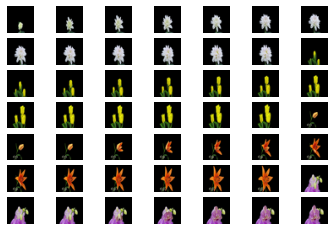

In [ ]:
for i in range(49):
	pyplot.subplot(7, 7, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(testX[i])
	pyplot.savefig('test.png')
pyplot.show()

***`Defining the discriminator model`***

In [ ]:
def discriminator_model(in_shape=(32,32,3)):
	discriminator = Sequential()
	# normal
	discriminator.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	discriminator.add(LeakyReLU(alpha=0.2))
	# downsample
	discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	discriminator.add(LeakyReLU(alpha=0.2))
	# downsample
	discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	discriminator.add(LeakyReLU(alpha=0.2))
	# downsample
	discriminator.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	discriminator.add(LeakyReLU(alpha=0.2))
	# classifier
	discriminator.add(Flatten())
	discriminator.add(Dropout(0.4))
	discriminator.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return discriminator

# define discriminator model
discriminator = discriminator_model()
# summary of the discriminator model
discriminator.summary()
# plot the model
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


***`Defining the generator model`***

In [ ]:
def generator_model(latent_dim):
	generator = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	generator.add(Dense(n_nodes, input_dim=latent_dim))
	generator.add(LeakyReLU(alpha=0.2))
	generator.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	generator.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	generator.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	generator.add(LeakyReLU(alpha=0.2))
	# output layer
	generator.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return generator

# define discriminator model
generator = generator_model(100)
# summary of the discriminator model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

***`Defining the combined models of generator and the discriminator for update the generator`***

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

***`Loading and preparing training images`***

In [ ]:
def load_real_samples():
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

***`Selecting real data from the training images`***

In [ ]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

***`Generating fake samples with the class `***

In [ ]:
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

***`Generating points in latent space as input for the generator`***

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

***`Generating fake samples with class labels`***

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

***`Evaluating the discriminator, plotting the generated videos and the models`***

In [ ]:
# accuracy_real = []
# accuracy_fake = []
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, d1_hist, d2_hist, g_hist, a1_hist, a2_hist, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # accuracy_real.append(acc_real*100)
  # accuracy_fake.append(acc_fake*100)
  # save plot
  save_plot(x_fake, epoch)

  plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, epoch)

  # save the generator model tile file
  filename = os.path.join(model_output_path, 'generator_model_%03d.h5' % (epoch+1))
  g_model.save(filename)

  # generating graph to compare losses
  filename = os.path.join(image_output_path,f"gan_loss_comparison_graph-{epoch+1}.png")
  pyplot.plot(d_losses1, label='Discriminator loss')
  pyplot.plot(g_losses, label='Generator loss')
  pyplot.legend()
  pyplot.savefig(filename)
  pyplot.close()

In [ ]:
# 
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, epoch):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(d1_hist, label='d-real')
  pyplot.plot(d2_hist, label='d-fake')
  pyplot.plot(g_hist, label='gen')
  pyplot.legend()
  # plot discriminator accuracy
  pyplot.subplot(2, 1, 2)
  pyplot.plot(a1_hist, label='acc-real')
  pyplot.plot(a2_hist, label='acc-fake')
  pyplot.legend()
  # save plot to file
  filename = os.path.join(output_path,f'graphs/plot_line_plot_loss-{epoch+1}.png')
  pyplot.savefig(filename)
  pyplot.close()

***`Save generated videos`***

In [ ]:
testing_output_path = os.path.join(output_path,'test_results')
if not os.path.exists(testing_output_path):
  os.makedirs(testing_output_path)

In [ ]:
def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  images = []

  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i])
    # saving images to an array
    images.append(examples[i])

  # save plot to file
  filename = os.path.join(image_output_path,f"generated_plot-{epoch+1}.png")
  pyplot.savefig(filename)
  pyplot.close()
  
  videoName = os.path.join(video_output_path,f"generated_video-{epoch+1}.mp4")
  # images = 255 * images
  # converted_images = np.array(images, dtype=np.uint8)
  converted_images = tf.image.resize(images, (256, 256)).numpy()
  imageio.mimsave(videoName, converted_images, fps=1)

***`Train both generator and discriminator models`***

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# d_losses1 = []
	# g_losses = []
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
			# save the discriminator loss at each epoch
			# d_losses1.append(d_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
	 		# save the generator loss at each epoch
			# g_losses.append(g_loss)

			d1_hist.append(d_loss1)
			d2_hist.append(d_loss2)
			g_hist.append(g_loss)
			a1_hist.append(d_acc1)
			a2_hist.append(d_acc2)
	 
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	 
		# evaluate the model performance
		if (i+1) % 1 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim, d1_hist, d2_hist, g_hist, a1_hist, a2_hist)

***`Training the models`***

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator_model()
# create the generator
g_model = generator_model(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, trainX, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>62, 4/35, d1=0.496, d2=0.438 g=1.283
>62, 5/35, d1=0.444, d2=0.466 g=1.295
>62, 6/35, d1=0.489, d2=0.444 g=1.341
>62, 7/35, d1=0.516, d2=0.545 g=1.286
>62, 8/35, d1=0.476, d2=0.428 g=1.443
>62, 9/35, d1=0.653, d2=0.517 g=1.401
>62, 10/35, d1=0.480, d2=0.457 g=1.260
>62, 11/35, d1=0.493, d2=0.559 g=1.517
>62, 12/35, d1=0.618, d2=0.417 g=1.356
>62, 13/35, d1=0.552, d2=0.451 g=1.280
>62, 14/35, d1=0.385, d2=0.471 g=1.494
>62, 15/35, d1=0.541, d2=0.444 g=1.413
>62, 16/35, d1=0.517, d2=0.479 g=1.489
>62, 17/35, d1=0.561, d2=0.451 g=1.506
>62, 18/35, d1=0.629, d2=0.449 g=1.327
>62, 19/35, d1=0.566, d2=0.475 g=1.230
>62, 20/35, d1=0.393, d2=0.497 g=1.381
>62, 21/35, d1=0.526, d2=0.505 g=1.419
>62, 22/35, d1=0.616, d2=0.430 g=1.273
>62, 23/35, d1=0.590, d2=0.563 g=1.217
>62, 24/35, d1=0.459, d2=0.510 g=1.289
>62, 25/35, d1=0.489, d2=0.500 g=1.484
>62, 26/35, d1=0.611, d2=0.406 g=1.403
>62, 27/35, d1=0.533, d2=0.468 g=1.359
>62, 28/35, d1=0.44

***`Testing the model`***

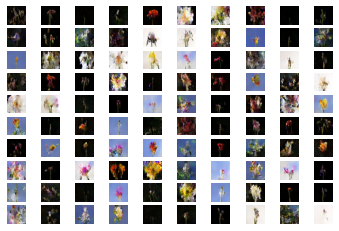

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('/content/drive/MyDrive/Data/Time-lapse/Output/models/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator_model()
# create the generator
g_model = load_model('/content/drive/MyDrive/Data/Time-lapse/Output/models/generator_model_200.h5')
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, testX, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/15, d1=3.956, d2=0.700 g=0.688
>1, 2/15, d1=0.012, d2=0.712 g=0.677
>1, 3/15, d1=0.007, d2=0.702 g=0.686
>1, 4/15, d1=0.042, d2=0.697 g=0.683
>1, 5/15, d1=0.001, d2=0.718 g=0.692
>1, 6/15, d1=0.000, d2=0.741 g=0.666
>1, 7/15, d1=0.002, d2=0.761 g=0.644
>1, 8/15, d1=0.005, d2=0.782 g=0.624
>1, 9/15, d1=0.000, d2=0.793 g=0.616
>1, 10/15, d1=0.002, d2=0.781 g=0.626
>1, 11/15, d1=0.000, d2=0.775 g=0.635
>1, 12/15, d1=0.011, d2=0.748 g=0.635
>1, 13/15, d1=0.023, d2=0.768 g=0.631
>1, 14/15, d1=0.008, d2=0.769 g=0.634
>1, 15/15, d1=0.005, d2=0.763 g=0.643
>Accuracy real: 100%, fake: 1%


>2, 1/15, d1=0.002, d2=0.753 g=0.654
>2, 2/15, d1=0.006, d2=0.748 g=0.662
>2, 3/15, d1=0.007, d2=0.734 g=0.671
>2, 4/15, d1=0.008, d2=0.730 g=0.674
>2, 5/15, d1=0.007, d2=0.732 g=0.677
>2, 6/15, d1=0.055, d2=0.729 g=0.663
>2, 7/15, d1=0.006, d2=0.730 g=0.659
>2, 8/15, d1=0.008, d2=0.736 g=0.667
>2, 9/15, d1=0.008, d2=0.724 g=0.672
>2, 10/15, d1=0.011, d2=0.719 g=0.679
>2, 11/15, d1=0.004, d2=0.715 g=0.690
>2, 12/15, d1=0.020, d2=0.707 g=0.692
>2, 13/15, d1=0.072, d2=0.721 g=0.673
>2, 14/15, d1=0.005, d2=0.721 g=0.678
>2, 15/15, d1=0.001, d2=0.724 g=0.693
>Accuracy real: 100%, fake: 51%


>3, 1/15, d1=0.013, d2=0.707 g=0.700
>3, 2/15, d1=0.010, d2=0.688 g=0.710
>3, 3/15, d1=0.003, d2=0.674 g=0.721
>3, 4/15, d1=0.104, d2=0.706 g=0.671
>3, 5/15, d1=0.008, d2=0.729 g=0.674
>3, 6/15, d1=0.001, d2=0.719 g=0.682
>3, 7/15, d1=0.004, d2=0.703 g=0.691
>3, 8/15, d1=0.008, d2=0.688 g=0.710
>3, 9/15, d1=0.006, d2=0.685 g=0.726
>3, 10/15, d1=0.008, d2=0.666 g=0.747
>3, 11/15, d1=0.016, d2=0.660 g=0.747
>3, 12/15, d1=0.004, d2=0.640 g=0.763
>3, 13/15, d1=0.003, d2=0.628 g=0.790
>3, 14/15, d1=0.080, d2=0.647 g=0.718
>3, 15/15, d1=0.001, d2=0.678 g=0.725
>Accuracy real: 100%, fake: 59%


>4, 1/15, d1=0.001, d2=0.669 g=0.744
>4, 2/15, d1=0.012, d2=0.636 g=0.783
>4, 3/15, d1=0.008, d2=0.611 g=0.819
>4, 4/15, d1=0.010, d2=0.570 g=0.866
>4, 5/15, d1=0.125, d2=0.622 g=0.747
>4, 6/15, d1=0.002, d2=0.652 g=0.755
>4, 7/15, d1=0.001, d2=0.641 g=0.783
>4, 8/15, d1=0.003, d2=0.602 g=0.834
>4, 9/15, d1=0.002, d2=0.567 g=0.891
>4, 10/15, d1=0.006, d2=0.515 g=0.960
>4, 11/15, d1=0.047, d2=0.514 g=0.944
>4, 12/15, d1=0.002, d2=0.499 g=0.990
>4, 13/15, d1=0.034, d2=0.515 g=0.920
>4, 14/15, d1=0.001, d2=0.517 g=0.962
>4, 15/15, d1=0.001, d2=0.480 g=1.050
>Accuracy real: 100%, fake: 100%


>5, 1/15, d1=0.040, d2=0.517 g=0.900
>5, 2/15, d1=0.000, d2=0.550 g=0.925
>5, 3/15, d1=0.001, d2=0.497 g=1.054
>5, 4/15, d1=0.002, d2=0.416 g=1.195
>5, 5/15, d1=0.004, d2=0.363 g=1.320
>5, 6/15, d1=0.117, d2=0.487 g=0.900
>5, 7/15, d1=0.000, d2=0.616 g=0.837
>5, 8/15, d1=0.001, d2=0.570 g=0.937
>5, 9/15, d1=0.000, d2=0.473 g=1.100
>5, 10/15, d1=0.000, d2=0.382 g=1.286
>5, 11/15, d1=0.001, d2=0.304 g=1.491
>5, 12/15, d1=0.063, d2=0.420 g=0.984
>5, 13/15, d1=0.000, d2=0.527 g=0.973
>5, 14/15, d1=0.000, d2=0.466 g=1.115
>5, 15/15, d1=0.000, d2=0.365 g=1.338
>Accuracy real: 100%, fake: 100%


>6, 1/15, d1=0.001, d2=0.281 g=1.573
>6, 2/15, d1=0.002, d2=0.220 g=1.839
>6, 3/15, d1=0.005, d2=0.186 g=1.926
>6, 4/15, d1=0.058, d2=0.256 g=1.420
>6, 5/15, d1=0.000, d2=0.304 g=1.440
>6, 6/15, d1=0.000, d2=0.258 g=1.697
>6, 7/15, d1=0.000, d2=0.190 g=1.963
>6, 8/15, d1=0.000, d2=0.137 g=2.270
>6, 9/15, d1=0.001, d2=0.105 g=2.474
>6, 10/15, d1=0.431, d2=0.584 g=0.589
>6, 11/15, d1=0.000, d2=1.254 g=0.410
>6, 12/15, d1=0.000, d2=1.191 g=0.463
>6, 13/15, d1=0.000, d2=0.966 g=0.557
>6, 14/15, d1=0.000, d2=0.830 g=0.642
>6, 15/15, d1=0.000, d2=0.734 g=0.697
>Accuracy real: 100%, fake: 19%


>7, 1/15, d1=0.000, d2=0.688 g=0.744
>7, 2/15, d1=0.001, d2=0.662 g=0.784
>7, 3/15, d1=0.008, d2=0.623 g=0.839
>7, 4/15, d1=0.002, d2=0.566 g=0.940
>7, 5/15, d1=0.000, d2=0.497 g=1.032
>7, 6/15, d1=0.002, d2=0.463 g=1.087
>7, 7/15, d1=0.043, d2=0.476 g=1.005
>7, 8/15, d1=0.000, d2=0.491 g=0.999
>7, 9/15, d1=0.000, d2=0.455 g=1.089
>7, 10/15, d1=0.004, d2=0.405 g=1.191
>7, 11/15, d1=0.002, d2=0.353 g=1.317
>7, 12/15, d1=0.005, d2=0.315 g=1.405
>7, 13/15, d1=0.039, d2=0.389 g=1.083
>7, 14/15, d1=0.000, d2=0.447 g=1.089
>7, 15/15, d1=0.000, d2=0.417 g=1.180
>Accuracy real: 100%, fake: 100%


>8, 1/15, d1=0.000, d2=0.349 g=1.333
>8, 2/15, d1=0.000, d2=0.290 g=1.493
>8, 3/15, d1=0.001, d2=0.244 g=1.647
>8, 4/15, d1=0.001, d2=0.209 g=1.811
>8, 5/15, d1=0.019, d2=0.179 g=1.906
>8, 6/15, d1=0.000, d2=0.156 g=2.059
>8, 7/15, d1=0.142, d2=0.243 g=1.403
>8, 8/15, d1=0.000, d2=0.342 g=1.329
>8, 9/15, d1=0.000, d2=0.311 g=1.520
>8, 10/15, d1=0.000, d2=0.231 g=1.790
>8, 11/15, d1=0.000, d2=0.171 g=2.046
>8, 12/15, d1=0.000, d2=0.131 g=2.265
>8, 13/15, d1=0.000, d2=0.109 g=2.437
>8, 14/15, d1=0.002, d2=0.090 g=2.594
>8, 15/15, d1=0.001, d2=0.075 g=2.739
>Accuracy real: 100%, fake: 100%


>9, 1/15, d1=0.003, d2=0.063 g=2.869
>9, 2/15, d1=0.003, d2=0.063 g=2.940
>9, 3/15, d1=0.006, d2=0.057 g=2.989
>9, 4/15, d1=0.002, d2=0.054 g=3.079
>9, 5/15, d1=0.003, d2=0.048 g=3.139
>9, 6/15, d1=0.002, d2=0.044 g=3.253
>9, 7/15, d1=0.002, d2=0.040 g=3.360
>9, 8/15, d1=0.004, d2=0.039 g=3.389
>9, 9/15, d1=0.002, d2=0.035 g=3.487
>9, 10/15, d1=0.009, d2=0.041 g=3.158
>9, 11/15, d1=0.000, d2=0.046 g=3.159
>9, 12/15, d1=0.000, d2=0.045 g=3.294
>9, 13/15, d1=0.001, d2=0.039 g=3.438
>9, 14/15, d1=0.000, d2=0.033 g=3.559
>9, 15/15, d1=0.000, d2=0.027 g=3.728
>Accuracy real: 100%, fake: 100%


>10, 1/15, d1=0.000, d2=0.025 g=3.814
>10, 2/15, d1=0.001, d2=0.022 g=3.917
>10, 3/15, d1=0.005, d2=0.019 g=4.002
>10, 4/15, d1=0.001, d2=0.019 g=4.027
>10, 5/15, d1=0.008, d2=0.022 g=3.794
>10, 6/15, d1=0.000, d2=0.024 g=3.848
>10, 7/15, d1=0.000, d2=0.021 g=3.954
>10, 8/15, d1=0.000, d2=0.020 g=3.994
>10, 9/15, d1=0.000, d2=0.018 g=4.166
>10, 10/15, d1=0.003, d2=0.017 g=4.180
>10, 11/15, d1=0.002, d2=0.015 g=4.264
>10, 12/15, d1=0.000, d2=0.015 g=4.372
>10, 13/15, d1=0.003, d2=0.013 g=4.393
>10, 14/15, d1=0.000, d2=0.012 g=4.459
>10, 15/15, d1=0.002, d2=0.011 g=4.495
>Accuracy real: 100%, fake: 100%


>11, 1/15, d1=0.000, d2=0.012 g=4.602
>11, 2/15, d1=0.004, d2=0.012 g=4.474
>11, 3/15, d1=0.000, d2=0.012 g=4.519
>11, 4/15, d1=0.000, d2=0.011 g=4.555
>11, 5/15, d1=0.001, d2=0.012 g=4.685
>11, 6/15, d1=0.002, d2=0.011 g=4.634
>11, 7/15, d1=0.000, d2=0.010 g=4.695
>11, 8/15, d1=0.000, d2=0.009 g=4.771
>11, 9/15, d1=0.000, d2=0.008 g=4.881
>11, 10/15, d1=0.000, d2=0.008 g=4.923
>11, 11/15, d1=0.001, d2=0.007 g=4.895
>11, 12/15, d1=0.001, d2=0.007 g=4.988
>11, 13/15, d1=0.000, d2=0.007 g=5.053
>11, 14/15, d1=0.001, d2=0.007 g=5.066
>11, 15/15, d1=0.001, d2=0.006 g=5.157
>Accuracy real: 100%, fake: 100%


>12, 1/15, d1=0.000, d2=0.006 g=5.124
>12, 2/15, d1=0.001, d2=0.006 g=5.136
>12, 3/15, d1=0.000, d2=0.006 g=5.212
>12, 4/15, d1=0.001, d2=0.006 g=5.193
>12, 5/15, d1=0.001, d2=0.006 g=5.219
>12, 6/15, d1=0.017, d2=0.007 g=4.840
>12, 7/15, d1=0.000, d2=0.009 g=4.731
>12, 8/15, d1=0.000, d2=0.009 g=4.817
>12, 9/15, d1=0.000, d2=0.009 g=4.866
>12, 10/15, d1=0.000, d2=0.008 g=4.964
>12, 11/15, d1=0.000, d2=0.007 g=5.020
>12, 12/15, d1=0.000, d2=0.007 g=5.102
>12, 13/15, d1=0.000, d2=0.007 g=5.217
>12, 14/15, d1=0.000, d2=0.006 g=5.267
>12, 15/15, d1=0.008, d2=0.007 g=5.098
>Accuracy real: 100%, fake: 100%


>13, 1/15, d1=0.000, d2=0.007 g=5.084
>13, 2/15, d1=0.000, d2=0.006 g=5.108
>13, 3/15, d1=0.000, d2=0.006 g=5.263
>13, 4/15, d1=0.000, d2=0.006 g=5.257
>13, 5/15, d1=0.000, d2=0.005 g=5.345
>13, 6/15, d1=0.000, d2=0.005 g=5.414
>13, 7/15, d1=0.000, d2=0.004 g=5.538
>13, 8/15, d1=0.000, d2=0.004 g=5.561
>13, 9/15, d1=0.000, d2=0.004 g=5.616
>13, 10/15, d1=0.000, d2=0.004 g=5.674
>13, 11/15, d1=0.000, d2=0.004 g=5.739
>13, 12/15, d1=0.000, d2=0.003 g=5.767
>13, 13/15, d1=0.000, d2=0.003 g=5.764
>13, 14/15, d1=0.000, d2=0.003 g=5.826
>13, 15/15, d1=0.000, d2=0.003 g=5.886
>Accuracy real: 100%, fake: 100%


>14, 1/15, d1=0.001, d2=0.003 g=5.858
>14, 2/15, d1=0.001, d2=0.003 g=5.845
>14, 3/15, d1=0.000, d2=0.003 g=5.880
>14, 4/15, d1=0.000, d2=0.003 g=5.933
>14, 5/15, d1=0.000, d2=0.003 g=5.965
>14, 6/15, d1=0.000, d2=0.003 g=6.041
>14, 7/15, d1=0.000, d2=0.003 g=6.021
>14, 8/15, d1=0.000, d2=0.002 g=6.139
>14, 9/15, d1=0.028, d2=0.005 g=5.054
>14, 10/15, d1=0.000, d2=0.008 g=4.852
>14, 11/15, d1=0.000, d2=0.009 g=4.859
>14, 12/15, d1=0.000, d2=0.008 g=4.996
>14, 13/15, d1=0.000, d2=0.007 g=5.113
>14, 14/15, d1=0.000, d2=0.006 g=5.186
>14, 15/15, d1=0.000, d2=0.006 g=5.322
>Accuracy real: 100%, fake: 100%


>15, 1/15, d1=0.000, d2=0.005 g=5.421
>15, 2/15, d1=0.000, d2=0.005 g=5.548
>15, 3/15, d1=0.000, d2=0.004 g=5.596
>15, 4/15, d1=0.000, d2=0.004 g=5.645
>15, 5/15, d1=0.000, d2=0.004 g=5.755
>15, 6/15, d1=0.000, d2=0.003 g=5.788
>15, 7/15, d1=0.000, d2=0.003 g=5.903
>15, 8/15, d1=0.000, d2=0.003 g=5.910
>15, 9/15, d1=0.000, d2=0.003 g=6.001
>15, 10/15, d1=0.000, d2=0.003 g=6.044
>15, 11/15, d1=0.000, d2=0.002 g=6.114
>15, 12/15, d1=0.000, d2=0.002 g=6.120
>15, 13/15, d1=0.000, d2=0.002 g=6.167
>15, 14/15, d1=0.000, d2=0.002 g=6.212
>15, 15/15, d1=0.000, d2=0.002 g=6.238
>Accuracy real: 100%, fake: 100%


>16, 1/15, d1=0.000, d2=0.002 g=6.325
>16, 2/15, d1=0.000, d2=0.002 g=6.369
>16, 3/15, d1=0.000, d2=0.002 g=6.378
>16, 4/15, d1=0.000, d2=0.002 g=6.368
>16, 5/15, d1=0.000, d2=0.002 g=6.426
>16, 6/15, d1=0.000, d2=0.002 g=6.447
>16, 7/15, d1=0.000, d2=0.002 g=6.499
>16, 8/15, d1=0.000, d2=0.002 g=6.506
>16, 9/15, d1=0.000, d2=0.001 g=6.554
>16, 10/15, d1=0.000, d2=0.001 g=6.559
>16, 11/15, d1=0.000, d2=0.001 g=6.701
>16, 12/15, d1=0.000, d2=0.001 g=6.688
>16, 13/15, d1=0.000, d2=0.001 g=6.685
>16, 14/15, d1=0.000, d2=0.001 g=6.714
>16, 15/15, d1=0.000, d2=0.001 g=6.775
>Accuracy real: 100%, fake: 100%


>17, 1/15, d1=0.000, d2=0.001 g=6.778
>17, 2/15, d1=0.000, d2=0.001 g=6.778
>17, 3/15, d1=0.000, d2=0.001 g=6.777
>17, 4/15, d1=0.000, d2=0.001 g=6.806
>17, 5/15, d1=0.000, d2=0.001 g=6.836
>17, 6/15, d1=0.000, d2=0.001 g=6.834
>17, 7/15, d1=0.000, d2=0.001 g=6.820
>17, 8/15, d1=0.000, d2=0.001 g=6.869
>17, 9/15, d1=0.000, d2=0.001 g=6.892
>17, 10/15, d1=0.000, d2=0.001 g=6.885
>17, 11/15, d1=0.000, d2=0.001 g=6.866
>17, 12/15, d1=0.000, d2=0.001 g=6.917
>17, 13/15, d1=0.000, d2=0.001 g=6.977
>17, 14/15, d1=0.001, d2=0.001 g=6.897
>17, 15/15, d1=0.000, d2=0.001 g=6.948
>Accuracy real: 100%, fake: 100%


>18, 1/15, d1=0.000, d2=0.001 g=6.901
>18, 2/15, d1=0.000, d2=0.001 g=6.930
>18, 3/15, d1=0.000, d2=0.001 g=6.974
>18, 4/15, d1=0.000, d2=0.001 g=6.937
>18, 5/15, d1=0.036, d2=0.020 g=2.718
>18, 6/15, d1=0.000, d2=0.679 g=3.657
>18, 7/15, d1=0.000, d2=0.008 g=5.716
>18, 8/15, d1=0.000, d2=0.003 g=6.350
>18, 9/15, d1=0.000, d2=0.002 g=6.368
>18, 10/15, d1=0.004, d2=0.002 g=6.185
>18, 11/15, d1=0.000, d2=0.002 g=6.120
>18, 12/15, d1=0.000, d2=0.002 g=6.147
>18, 13/15, d1=0.000, d2=0.002 g=6.140
>18, 14/15, d1=0.003, d2=0.003 g=6.032
>18, 15/15, d1=0.000, d2=0.002 g=6.044
>Accuracy real: 100%, fake: 100%


>19, 1/15, d1=0.000, d2=0.003 g=6.094
>19, 2/15, d1=0.000, d2=0.002 g=6.086
>19, 3/15, d1=0.000, d2=0.002 g=6.176
>19, 4/15, d1=0.000, d2=0.002 g=6.217
>19, 5/15, d1=0.001, d2=0.002 g=6.307
>19, 6/15, d1=0.000, d2=0.002 g=6.294
>19, 7/15, d1=0.000, d2=0.002 g=6.339
>19, 8/15, d1=0.000, d2=0.002 g=6.411
>19, 9/15, d1=0.000, d2=0.002 g=6.442
>19, 10/15, d1=0.000, d2=0.002 g=6.470
>19, 11/15, d1=0.000, d2=0.002 g=6.559
>19, 12/15, d1=0.000, d2=0.002 g=6.575
>19, 13/15, d1=0.000, d2=0.002 g=6.612
>19, 14/15, d1=0.000, d2=0.001 g=6.663
>19, 15/15, d1=0.000, d2=0.001 g=6.647
>Accuracy real: 100%, fake: 100%


>20, 1/15, d1=0.000, d2=0.001 g=6.702
>20, 2/15, d1=0.000, d2=0.001 g=6.680
>20, 3/15, d1=0.000, d2=0.001 g=6.702
>20, 4/15, d1=0.000, d2=0.001 g=6.784
>20, 5/15, d1=0.000, d2=0.001 g=6.797
>20, 6/15, d1=0.000, d2=0.001 g=6.862
>20, 7/15, d1=0.000, d2=0.001 g=6.865
>20, 8/15, d1=0.000, d2=0.001 g=6.855
>20, 9/15, d1=0.000, d2=0.001 g=6.869
>20, 10/15, d1=0.000, d2=0.001 g=6.933
>20, 11/15, d1=0.000, d2=0.001 g=6.930
>20, 12/15, d1=0.000, d2=0.001 g=6.903
>20, 13/15, d1=0.000, d2=0.001 g=6.930
>20, 14/15, d1=0.000, d2=0.001 g=6.996
>20, 15/15, d1=0.000, d2=0.001 g=7.003
>Accuracy real: 100%, fake: 100%


>21, 1/15, d1=0.000, d2=0.001 g=7.060
>21, 2/15, d1=0.000, d2=0.001 g=7.039
>21, 3/15, d1=0.000, d2=0.001 g=7.067
>21, 4/15, d1=0.000, d2=0.001 g=7.091
>21, 5/15, d1=0.000, d2=0.001 g=7.097
>21, 6/15, d1=0.000, d2=0.001 g=7.131
>21, 7/15, d1=0.000, d2=0.001 g=7.127
>21, 8/15, d1=0.000, d2=0.001 g=7.160
>21, 9/15, d1=0.002, d2=0.001 g=7.107
>21, 10/15, d1=0.000, d2=0.001 g=7.079
>21, 11/15, d1=0.000, d2=0.001 g=7.147
>21, 12/15, d1=0.000, d2=0.001 g=7.179
>21, 13/15, d1=0.000, d2=0.001 g=7.155
>21, 14/15, d1=0.000, d2=0.001 g=7.218
>21, 15/15, d1=0.000, d2=0.001 g=7.204
>Accuracy real: 100%, fake: 100%


>22, 1/15, d1=0.000, d2=0.001 g=7.257
>22, 2/15, d1=0.000, d2=0.001 g=7.267
>22, 3/15, d1=0.000, d2=0.001 g=7.241
>22, 4/15, d1=0.000, d2=0.001 g=7.294
>22, 5/15, d1=0.000, d2=0.001 g=7.288
>22, 6/15, d1=0.000, d2=0.001 g=7.312
>22, 7/15, d1=0.002, d2=0.001 g=7.287
>22, 8/15, d1=0.000, d2=0.001 g=7.304
>22, 9/15, d1=0.000, d2=0.001 g=7.292
>22, 10/15, d1=0.001, d2=0.001 g=7.304
>22, 11/15, d1=0.000, d2=0.001 g=7.377
>22, 12/15, d1=0.000, d2=0.001 g=7.350
>22, 13/15, d1=0.000, d2=0.001 g=7.377
>22, 14/15, d1=0.000, d2=0.001 g=7.371
>22, 15/15, d1=0.000, d2=0.001 g=7.337
>Accuracy real: 100%, fake: 100%


>23, 1/15, d1=0.000, d2=0.001 g=7.398
>23, 2/15, d1=0.000, d2=0.001 g=7.423
>23, 3/15, d1=0.000, d2=0.001 g=7.355
>23, 4/15, d1=0.001, d2=0.001 g=7.397
>23, 5/15, d1=0.000, d2=0.001 g=7.463
>23, 6/15, d1=0.000, d2=0.001 g=7.432
>23, 7/15, d1=0.000, d2=0.001 g=7.451
>23, 8/15, d1=0.000, d2=0.001 g=7.410
>23, 9/15, d1=0.000, d2=0.001 g=7.479
>23, 10/15, d1=0.000, d2=0.001 g=7.520
>23, 11/15, d1=0.000, d2=0.001 g=7.455
>23, 12/15, d1=0.000, d2=0.001 g=7.483
>23, 13/15, d1=0.000, d2=0.001 g=7.490
>23, 14/15, d1=0.000, d2=0.001 g=7.514
>23, 15/15, d1=0.000, d2=0.001 g=7.532
>Accuracy real: 100%, fake: 100%


>24, 1/15, d1=0.000, d2=0.001 g=7.531
>24, 2/15, d1=0.000, d2=0.001 g=7.596
>24, 3/15, d1=0.000, d2=0.001 g=7.594
>24, 4/15, d1=0.000, d2=0.001 g=7.554
>24, 5/15, d1=0.000, d2=0.001 g=7.524
>24, 6/15, d1=0.000, d2=0.001 g=7.620
>24, 7/15, d1=0.000, d2=0.001 g=7.613
>24, 8/15, d1=0.000, d2=0.001 g=7.632
>24, 9/15, d1=0.000, d2=0.000 g=7.727
>24, 10/15, d1=0.000, d2=0.000 g=7.640
>24, 11/15, d1=0.000, d2=0.000 g=7.705
>24, 12/15, d1=0.000, d2=0.001 g=7.700
>24, 13/15, d1=0.000, d2=0.001 g=7.664
>24, 14/15, d1=0.000, d2=0.000 g=7.730
>24, 15/15, d1=0.000, d2=0.000 g=7.724
>Accuracy real: 100%, fake: 100%


>25, 1/15, d1=0.000, d2=0.000 g=7.717
>25, 2/15, d1=0.000, d2=0.000 g=7.649
>25, 3/15, d1=0.000, d2=0.000 g=7.709
>25, 4/15, d1=0.000, d2=0.000 g=7.727
>25, 5/15, d1=0.000, d2=0.001 g=7.753
>25, 6/15, d1=0.000, d2=0.000 g=7.748
>25, 7/15, d1=0.000, d2=0.000 g=7.753
>25, 8/15, d1=0.000, d2=0.000 g=7.777
>25, 9/15, d1=0.000, d2=0.000 g=7.739
>25, 10/15, d1=0.000, d2=0.000 g=7.789
>25, 11/15, d1=0.000, d2=0.000 g=7.812
>25, 12/15, d1=0.000, d2=0.000 g=7.825
>25, 13/15, d1=0.000, d2=0.000 g=7.826
>25, 14/15, d1=0.000, d2=0.000 g=7.798
>25, 15/15, d1=0.000, d2=0.000 g=7.771
>Accuracy real: 100%, fake: 100%


>26, 1/15, d1=0.000, d2=0.000 g=7.836
>26, 2/15, d1=0.000, d2=0.000 g=7.805
>26, 3/15, d1=0.000, d2=0.000 g=7.843
>26, 4/15, d1=0.000, d2=0.000 g=7.893
>26, 5/15, d1=0.000, d2=0.000 g=7.856
>26, 6/15, d1=0.000, d2=0.000 g=7.874
>26, 7/15, d1=0.000, d2=0.000 g=7.816
>26, 8/15, d1=0.000, d2=0.000 g=7.881
>26, 9/15, d1=0.001, d2=0.000 g=7.769
>26, 10/15, d1=0.002, d2=0.000 g=7.662
>26, 11/15, d1=0.000, d2=0.000 g=7.716
>26, 12/15, d1=0.001, d2=0.000 g=7.729
>26, 13/15, d1=0.000, d2=0.001 g=7.704
>26, 14/15, d1=0.000, d2=0.000 g=7.729
>26, 15/15, d1=0.000, d2=0.000 g=7.716
>Accuracy real: 100%, fake: 100%


>27, 1/15, d1=0.000, d2=0.001 g=7.810
>27, 2/15, d1=0.000, d2=0.000 g=7.741
>27, 3/15, d1=0.000, d2=0.000 g=7.803
>27, 4/15, d1=0.000, d2=0.000 g=7.756
>27, 5/15, d1=0.000, d2=0.000 g=7.851
>27, 6/15, d1=0.000, d2=0.000 g=7.858
>27, 7/15, d1=0.001, d2=0.000 g=7.826
>27, 8/15, d1=0.000, d2=0.000 g=7.801
>27, 9/15, d1=0.000, d2=0.000 g=7.826
>27, 10/15, d1=0.000, d2=0.000 g=7.870
>27, 11/15, d1=0.000, d2=0.000 g=7.835
>27, 12/15, d1=0.000, d2=0.000 g=7.874
>27, 13/15, d1=0.000, d2=0.000 g=7.932
>27, 14/15, d1=0.000, d2=0.000 g=7.852
>27, 15/15, d1=0.000, d2=0.000 g=7.877
>Accuracy real: 100%, fake: 100%


>28, 1/15, d1=0.000, d2=0.000 g=7.893
>28, 2/15, d1=0.000, d2=0.000 g=7.904
>28, 3/15, d1=0.000, d2=0.000 g=7.957
>28, 4/15, d1=0.000, d2=0.000 g=7.983
>28, 5/15, d1=0.000, d2=0.000 g=7.934
>28, 6/15, d1=0.000, d2=0.000 g=7.982
>28, 7/15, d1=0.000, d2=0.000 g=7.984
>28, 8/15, d1=0.000, d2=0.000 g=7.945
>28, 9/15, d1=0.000, d2=0.000 g=7.991
>28, 10/15, d1=0.000, d2=0.000 g=7.957
>28, 11/15, d1=0.000, d2=0.000 g=7.989
>28, 12/15, d1=0.000, d2=0.000 g=7.987
>28, 13/15, d1=0.000, d2=0.000 g=8.121
>28, 14/15, d1=0.000, d2=0.000 g=8.016
>28, 15/15, d1=0.000, d2=0.000 g=8.048
>Accuracy real: 100%, fake: 100%


>29, 1/15, d1=0.000, d2=0.000 g=8.078
>29, 2/15, d1=0.000, d2=0.000 g=8.035
>29, 3/15, d1=0.000, d2=0.000 g=8.070
>29, 4/15, d1=0.000, d2=0.000 g=8.046
>29, 5/15, d1=0.000, d2=0.000 g=8.056
>29, 6/15, d1=0.000, d2=0.000 g=8.031
>29, 7/15, d1=0.000, d2=0.000 g=8.046
>29, 8/15, d1=0.000, d2=0.000 g=8.077
>29, 9/15, d1=0.000, d2=0.000 g=8.146
>29, 10/15, d1=0.000, d2=0.000 g=8.115
>29, 11/15, d1=0.000, d2=0.000 g=8.103
>29, 12/15, d1=0.000, d2=0.000 g=8.043
>29, 13/15, d1=0.000, d2=0.000 g=8.082
>29, 14/15, d1=0.000, d2=0.000 g=8.101
>29, 15/15, d1=0.000, d2=0.000 g=8.107
>Accuracy real: 100%, fake: 100%


>30, 1/15, d1=0.000, d2=0.000 g=8.174
>30, 2/15, d1=0.000, d2=0.000 g=8.085
>30, 3/15, d1=0.000, d2=0.000 g=8.156
>30, 4/15, d1=0.000, d2=0.000 g=8.117
>30, 5/15, d1=0.000, d2=0.000 g=8.084
>30, 6/15, d1=0.000, d2=0.000 g=8.068
>30, 7/15, d1=0.000, d2=0.000 g=8.069
>30, 8/15, d1=0.000, d2=0.000 g=8.149
>30, 9/15, d1=0.000, d2=0.000 g=8.172
>30, 10/15, d1=0.000, d2=0.000 g=8.186
>30, 11/15, d1=0.000, d2=0.000 g=8.134
>30, 12/15, d1=0.000, d2=0.000 g=8.241
>30, 13/15, d1=0.000, d2=0.000 g=8.205
>30, 14/15, d1=0.000, d2=0.000 g=8.257
>30, 15/15, d1=0.000, d2=0.000 g=8.190
>Accuracy real: 100%, fake: 100%


>31, 1/15, d1=0.000, d2=0.000 g=8.189
>31, 2/15, d1=0.000, d2=0.000 g=8.171
>31, 3/15, d1=0.000, d2=0.000 g=8.228
>31, 4/15, d1=0.000, d2=0.000 g=8.237
>31, 5/15, d1=0.000, d2=0.000 g=8.240
>31, 6/15, d1=0.000, d2=0.000 g=8.270
>31, 7/15, d1=0.000, d2=0.000 g=8.162
>31, 8/15, d1=0.000, d2=0.000 g=8.292
>31, 9/15, d1=0.000, d2=0.000 g=8.183
>31, 10/15, d1=0.000, d2=0.000 g=8.167
>31, 11/15, d1=0.000, d2=0.000 g=8.221
>31, 12/15, d1=0.000, d2=0.000 g=8.246
>31, 13/15, d1=0.000, d2=0.000 g=8.208
>31, 14/15, d1=0.000, d2=0.000 g=8.217
>31, 15/15, d1=0.000, d2=0.000 g=8.180
>Accuracy real: 100%, fake: 100%


>32, 1/15, d1=0.000, d2=0.000 g=8.202
>32, 2/15, d1=0.001, d2=0.000 g=8.079
>32, 3/15, d1=0.000, d2=0.000 g=8.096
>32, 4/15, d1=0.000, d2=0.000 g=8.053
>32, 5/15, d1=0.000, d2=0.000 g=8.048
>32, 6/15, d1=0.000, d2=0.000 g=8.124
>32, 7/15, d1=0.000, d2=0.000 g=8.122
>32, 8/15, d1=0.000, d2=0.000 g=8.172
>32, 9/15, d1=0.000, d2=0.000 g=8.130
>32, 10/15, d1=0.000, d2=0.000 g=8.186
>32, 11/15, d1=0.000, d2=0.000 g=8.060
>32, 12/15, d1=0.000, d2=0.000 g=8.157
>32, 13/15, d1=0.000, d2=0.000 g=8.194
>32, 14/15, d1=0.000, d2=0.000 g=8.158
>32, 15/15, d1=0.000, d2=0.000 g=8.150
>Accuracy real: 100%, fake: 100%


>33, 1/15, d1=0.000, d2=0.000 g=8.252
>33, 2/15, d1=0.000, d2=0.000 g=8.160
>33, 3/15, d1=0.000, d2=0.000 g=8.308
>33, 4/15, d1=0.000, d2=0.000 g=8.254
>33, 5/15, d1=0.000, d2=0.000 g=8.262
>33, 6/15, d1=0.000, d2=0.000 g=8.227
>33, 7/15, d1=0.000, d2=0.000 g=8.314
>33, 8/15, d1=0.000, d2=0.000 g=8.312
>33, 9/15, d1=0.000, d2=0.000 g=8.338
>33, 10/15, d1=0.000, d2=0.000 g=8.328
>33, 11/15, d1=0.000, d2=0.000 g=8.384
>33, 12/15, d1=0.000, d2=0.000 g=8.364
>33, 13/15, d1=0.000, d2=0.000 g=8.362
>33, 14/15, d1=0.000, d2=0.000 g=8.323
>33, 15/15, d1=0.000, d2=0.000 g=8.392
>Accuracy real: 100%, fake: 100%


>34, 1/15, d1=0.000, d2=0.000 g=8.366
>34, 2/15, d1=0.000, d2=0.000 g=8.381
>34, 3/15, d1=0.000, d2=0.000 g=8.385
>34, 4/15, d1=0.000, d2=0.000 g=8.414
>34, 5/15, d1=0.000, d2=0.000 g=8.459
>34, 6/15, d1=0.000, d2=0.000 g=8.382
>34, 7/15, d1=0.000, d2=0.000 g=8.494
>34, 8/15, d1=0.000, d2=0.000 g=8.424
>34, 9/15, d1=0.000, d2=0.000 g=8.460
>34, 10/15, d1=0.000, d2=0.000 g=8.404
>34, 11/15, d1=0.000, d2=0.000 g=8.464
>34, 12/15, d1=0.000, d2=0.000 g=8.419
>34, 13/15, d1=0.000, d2=0.000 g=8.465
>34, 14/15, d1=0.000, d2=0.000 g=8.514
>34, 15/15, d1=0.000, d2=0.000 g=8.434
>Accuracy real: 100%, fake: 100%


>35, 1/15, d1=0.000, d2=0.000 g=8.527
>35, 2/15, d1=0.000, d2=0.000 g=8.586
>35, 3/15, d1=0.000, d2=0.000 g=8.543
>35, 4/15, d1=0.000, d2=0.000 g=8.583
>35, 5/15, d1=0.000, d2=0.000 g=8.541
>35, 6/15, d1=0.000, d2=0.000 g=8.585
>35, 7/15, d1=0.000, d2=0.000 g=8.499
>35, 8/15, d1=0.000, d2=0.000 g=8.478
>35, 9/15, d1=0.000, d2=0.000 g=8.612
>35, 10/15, d1=0.000, d2=0.000 g=8.645
>35, 11/15, d1=0.000, d2=0.000 g=8.571
>35, 12/15, d1=0.000, d2=0.000 g=8.557
>35, 13/15, d1=0.000, d2=0.000 g=8.651
>35, 14/15, d1=0.000, d2=0.000 g=8.618
>35, 15/15, d1=0.000, d2=0.000 g=8.600
>Accuracy real: 100%, fake: 100%


>36, 1/15, d1=0.000, d2=0.000 g=8.677
>36, 2/15, d1=0.000, d2=0.000 g=8.684
>36, 3/15, d1=0.000, d2=0.000 g=8.612
>36, 4/15, d1=0.000, d2=0.000 g=8.693
>36, 5/15, d1=0.000, d2=0.000 g=8.618
>36, 6/15, d1=0.000, d2=0.000 g=8.644
>36, 7/15, d1=0.000, d2=0.000 g=8.725
>36, 8/15, d1=0.000, d2=0.000 g=8.682
>36, 9/15, d1=0.000, d2=0.000 g=8.627
>36, 10/15, d1=0.000, d2=0.000 g=8.699
>36, 11/15, d1=0.000, d2=0.000 g=8.697
>36, 12/15, d1=0.000, d2=0.000 g=8.757
>36, 13/15, d1=0.000, d2=0.000 g=8.698
>36, 14/15, d1=0.000, d2=0.000 g=8.665
>36, 15/15, d1=0.000, d2=0.000 g=8.785
>Accuracy real: 100%, fake: 100%


>37, 1/15, d1=0.000, d2=0.000 g=8.698
>37, 2/15, d1=0.000, d2=0.000 g=8.694
>37, 3/15, d1=0.000, d2=0.000 g=8.705
>37, 4/15, d1=0.000, d2=0.000 g=8.694
>37, 5/15, d1=0.000, d2=0.000 g=8.740
>37, 6/15, d1=0.000, d2=0.000 g=8.702
>37, 7/15, d1=0.000, d2=0.000 g=8.734
>37, 8/15, d1=0.000, d2=0.000 g=8.763
>37, 9/15, d1=0.000, d2=0.000 g=8.726
>37, 10/15, d1=0.000, d2=0.000 g=8.756
>37, 11/15, d1=0.000, d2=0.000 g=8.837
>37, 12/15, d1=0.000, d2=0.000 g=8.816
>37, 13/15, d1=0.000, d2=0.000 g=8.780
>37, 14/15, d1=0.000, d2=0.000 g=8.842
>37, 15/15, d1=0.000, d2=0.000 g=8.776
>Accuracy real: 100%, fake: 100%


>38, 1/15, d1=0.000, d2=0.000 g=8.812
>38, 2/15, d1=0.000, d2=0.000 g=8.826
>38, 3/15, d1=0.000, d2=0.000 g=8.819
>38, 4/15, d1=0.000, d2=0.000 g=8.834
>38, 5/15, d1=0.000, d2=0.000 g=8.807
>38, 6/15, d1=0.000, d2=0.000 g=8.878
>38, 7/15, d1=0.000, d2=0.000 g=8.795
>38, 8/15, d1=0.000, d2=0.000 g=8.881
>38, 9/15, d1=0.000, d2=0.000 g=8.784
>38, 10/15, d1=0.000, d2=0.000 g=8.893
>38, 11/15, d1=0.000, d2=0.000 g=8.780
>38, 12/15, d1=0.000, d2=0.000 g=8.862
>38, 13/15, d1=0.000, d2=0.000 g=8.888
>38, 14/15, d1=0.000, d2=0.000 g=8.866
>38, 15/15, d1=0.000, d2=0.000 g=8.854
>Accuracy real: 100%, fake: 100%


>39, 1/15, d1=0.000, d2=0.000 g=8.856
>39, 2/15, d1=0.000, d2=0.000 g=8.886
>39, 3/15, d1=0.000, d2=0.000 g=8.895
>39, 4/15, d1=0.000, d2=0.000 g=8.927
>39, 5/15, d1=0.000, d2=0.000 g=8.880
>39, 6/15, d1=0.000, d2=0.000 g=8.917
>39, 7/15, d1=0.000, d2=0.000 g=8.945
>39, 8/15, d1=0.000, d2=0.000 g=8.861
>39, 9/15, d1=0.000, d2=0.000 g=8.877
>39, 10/15, d1=0.000, d2=0.000 g=8.923
>39, 11/15, d1=0.000, d2=0.000 g=8.905
>39, 12/15, d1=0.000, d2=0.000 g=8.816
>39, 13/15, d1=0.000, d2=0.000 g=8.850
>39, 14/15, d1=0.000, d2=0.000 g=8.940
>39, 15/15, d1=0.000, d2=0.000 g=8.898
>Accuracy real: 100%, fake: 100%


>40, 1/15, d1=0.000, d2=0.000 g=8.844
>40, 2/15, d1=0.000, d2=0.000 g=8.970
>40, 3/15, d1=0.000, d2=0.000 g=8.954
>40, 4/15, d1=0.000, d2=0.000 g=8.948
>40, 5/15, d1=0.000, d2=0.000 g=8.853
>40, 6/15, d1=0.000, d2=0.000 g=8.949
>40, 7/15, d1=0.000, d2=0.000 g=8.915
>40, 8/15, d1=0.000, d2=0.000 g=8.962
>40, 9/15, d1=0.000, d2=0.000 g=8.973
>40, 10/15, d1=0.000, d2=0.000 g=8.940
>40, 11/15, d1=0.000, d2=0.000 g=8.880
>40, 12/15, d1=0.000, d2=0.000 g=9.023
>40, 13/15, d1=0.000, d2=0.000 g=8.978
>40, 14/15, d1=0.000, d2=0.000 g=8.937
>40, 15/15, d1=0.000, d2=0.000 g=8.877
>Accuracy real: 100%, fake: 100%


>41, 1/15, d1=0.000, d2=0.000 g=8.986
>41, 2/15, d1=0.000, d2=0.000 g=9.018
>41, 3/15, d1=0.000, d2=0.000 g=8.989
>41, 4/15, d1=0.000, d2=0.000 g=9.002
>41, 5/15, d1=0.000, d2=0.000 g=8.956
>41, 6/15, d1=0.000, d2=0.000 g=9.007
>41, 7/15, d1=0.000, d2=0.000 g=9.008
>41, 8/15, d1=0.000, d2=0.000 g=9.040
>41, 9/15, d1=0.000, d2=0.000 g=9.063
>41, 10/15, d1=0.000, d2=0.000 g=9.005
>41, 11/15, d1=0.000, d2=0.000 g=8.943
>41, 12/15, d1=0.000, d2=0.000 g=9.100
>41, 13/15, d1=0.000, d2=0.000 g=9.079
>41, 14/15, d1=0.000, d2=0.000 g=9.072
>41, 15/15, d1=0.000, d2=0.000 g=8.965
>Accuracy real: 100%, fake: 100%


>42, 1/15, d1=0.000, d2=0.000 g=9.052
>42, 2/15, d1=0.000, d2=0.000 g=9.083
>42, 3/15, d1=0.000, d2=0.000 g=9.005
>42, 4/15, d1=0.000, d2=0.000 g=9.110
>42, 5/15, d1=0.000, d2=0.000 g=9.077
>42, 6/15, d1=0.000, d2=0.000 g=9.118
>42, 7/15, d1=0.000, d2=0.000 g=8.979
>42, 8/15, d1=0.000, d2=0.000 g=9.062
>42, 9/15, d1=0.000, d2=0.000 g=9.091
>42, 10/15, d1=0.000, d2=0.000 g=9.072
>42, 11/15, d1=0.000, d2=0.000 g=9.076
>42, 12/15, d1=0.000, d2=0.000 g=9.198
>42, 13/15, d1=0.000, d2=0.000 g=9.106
>42, 14/15, d1=0.000, d2=0.000 g=9.081
>42, 15/15, d1=0.000, d2=0.000 g=9.095
>Accuracy real: 100%, fake: 100%


>43, 1/15, d1=0.000, d2=0.000 g=9.160
>43, 2/15, d1=0.000, d2=0.000 g=9.116
>43, 3/15, d1=0.000, d2=0.000 g=9.089
>43, 4/15, d1=0.000, d2=0.000 g=9.146
>43, 5/15, d1=0.000, d2=0.000 g=9.109
>43, 6/15, d1=0.000, d2=0.000 g=9.221
>43, 7/15, d1=0.000, d2=0.000 g=9.162
>43, 8/15, d1=0.000, d2=0.000 g=9.181
>43, 9/15, d1=0.000, d2=0.000 g=9.199
>43, 10/15, d1=0.000, d2=0.000 g=9.152
>43, 11/15, d1=0.000, d2=0.000 g=9.152
>43, 12/15, d1=0.000, d2=0.000 g=9.226
>43, 13/15, d1=0.000, d2=0.000 g=9.160
>43, 14/15, d1=0.000, d2=0.000 g=9.229
>43, 15/15, d1=0.000, d2=0.000 g=9.249
>Accuracy real: 100%, fake: 100%


>44, 1/15, d1=0.000, d2=0.000 g=9.209
>44, 2/15, d1=0.000, d2=0.000 g=9.191
>44, 3/15, d1=0.000, d2=0.000 g=9.260
>44, 4/15, d1=0.000, d2=0.000 g=9.184
>44, 5/15, d1=0.000, d2=0.000 g=9.236
>44, 6/15, d1=0.000, d2=0.000 g=9.156
>44, 7/15, d1=0.000, d2=0.000 g=9.211
>44, 8/15, d1=0.000, d2=0.000 g=9.226
>44, 9/15, d1=0.000, d2=0.000 g=9.177
>44, 10/15, d1=0.000, d2=0.000 g=9.212
>44, 11/15, d1=0.000, d2=0.000 g=9.224
>44, 12/15, d1=0.000, d2=0.000 g=9.242
>44, 13/15, d1=0.000, d2=0.000 g=9.191
>44, 14/15, d1=0.000, d2=0.000 g=9.250
>44, 15/15, d1=0.000, d2=0.000 g=9.252
>Accuracy real: 100%, fake: 100%


>45, 1/15, d1=0.001, d2=0.000 g=9.102
>45, 2/15, d1=0.000, d2=0.000 g=9.092
>45, 3/15, d1=0.000, d2=0.000 g=9.124
>45, 4/15, d1=0.000, d2=0.000 g=9.154
>45, 5/15, d1=0.000, d2=0.000 g=9.173
>45, 6/15, d1=0.000, d2=0.000 g=9.225
>45, 7/15, d1=0.000, d2=0.000 g=9.213
>45, 8/15, d1=0.000, d2=0.000 g=9.216
>45, 9/15, d1=0.000, d2=0.000 g=9.256
>45, 10/15, d1=0.000, d2=0.000 g=9.163
>45, 11/15, d1=0.000, d2=0.000 g=9.229
>45, 12/15, d1=0.000, d2=0.000 g=9.146
>45, 13/15, d1=0.000, d2=0.000 g=9.247
>45, 14/15, d1=0.000, d2=0.000 g=9.231
>45, 15/15, d1=0.000, d2=0.000 g=9.162
>Accuracy real: 100%, fake: 100%


>46, 1/15, d1=0.000, d2=0.000 g=9.174
>46, 2/15, d1=0.000, d2=0.000 g=9.271
>46, 3/15, d1=0.000, d2=0.000 g=9.179
>46, 4/15, d1=0.000, d2=0.000 g=9.259
>46, 5/15, d1=0.000, d2=0.000 g=9.244
>46, 6/15, d1=0.000, d2=0.000 g=9.243
>46, 7/15, d1=0.000, d2=0.000 g=9.278
>46, 8/15, d1=0.000, d2=0.000 g=9.304
>46, 9/15, d1=0.000, d2=0.000 g=9.277
>46, 10/15, d1=0.000, d2=0.000 g=9.214
>46, 11/15, d1=0.000, d2=0.000 g=9.295
>46, 12/15, d1=0.000, d2=0.000 g=9.215
>46, 13/15, d1=0.000, d2=0.000 g=9.231
>46, 14/15, d1=0.000, d2=0.000 g=9.370
>46, 15/15, d1=0.000, d2=0.000 g=9.268
>Accuracy real: 100%, fake: 100%


>47, 1/15, d1=0.000, d2=0.000 g=9.223
>47, 2/15, d1=0.000, d2=0.000 g=9.217
>47, 3/15, d1=0.000, d2=0.000 g=9.347
>47, 4/15, d1=0.000, d2=0.000 g=9.238
>47, 5/15, d1=0.000, d2=0.000 g=9.324
>47, 6/15, d1=0.000, d2=0.000 g=9.335
>47, 7/15, d1=0.000, d2=0.000 g=9.283
>47, 8/15, d1=0.000, d2=0.000 g=9.392
>47, 9/15, d1=0.000, d2=0.000 g=9.278
>47, 10/15, d1=0.000, d2=0.000 g=9.304
>47, 11/15, d1=0.000, d2=0.000 g=9.346
>47, 12/15, d1=0.000, d2=0.000 g=9.348
>47, 13/15, d1=0.000, d2=0.000 g=9.315
>47, 14/15, d1=0.000, d2=0.000 g=9.335
>47, 15/15, d1=0.000, d2=0.000 g=9.373
>Accuracy real: 100%, fake: 100%


>48, 1/15, d1=0.000, d2=0.000 g=9.331
>48, 2/15, d1=0.000, d2=0.000 g=9.302
>48, 3/15, d1=0.000, d2=0.000 g=9.396
>48, 4/15, d1=0.000, d2=0.000 g=9.345
>48, 5/15, d1=0.000, d2=0.000 g=9.226
>48, 6/15, d1=0.000, d2=0.000 g=9.338
>48, 7/15, d1=0.000, d2=0.000 g=9.450
>48, 8/15, d1=0.000, d2=0.000 g=9.384
>48, 9/15, d1=0.000, d2=0.000 g=9.352
>48, 10/15, d1=0.000, d2=0.000 g=9.373
>48, 11/15, d1=0.000, d2=0.000 g=9.320
>48, 12/15, d1=0.000, d2=0.000 g=9.335
>48, 13/15, d1=0.000, d2=0.000 g=9.355
>48, 14/15, d1=0.000, d2=0.000 g=9.413
>48, 15/15, d1=0.000, d2=0.000 g=9.395
>Accuracy real: 100%, fake: 100%


>49, 1/15, d1=0.000, d2=0.000 g=9.326
>49, 2/15, d1=0.000, d2=0.000 g=9.406
>49, 3/15, d1=0.000, d2=0.000 g=9.421
>49, 4/15, d1=0.000, d2=0.000 g=9.374
>49, 5/15, d1=0.000, d2=0.000 g=9.484
>49, 6/15, d1=0.000, d2=0.000 g=9.472
>49, 7/15, d1=0.000, d2=0.000 g=9.415
>49, 8/15, d1=0.000, d2=0.000 g=9.395
>49, 9/15, d1=0.000, d2=0.000 g=9.373
>49, 10/15, d1=0.000, d2=0.000 g=9.398
>49, 11/15, d1=0.000, d2=0.000 g=9.408
>49, 12/15, d1=0.000, d2=0.000 g=9.487
>49, 13/15, d1=0.000, d2=0.000 g=9.456
>49, 14/15, d1=0.000, d2=0.000 g=9.424
>49, 15/15, d1=0.000, d2=0.000 g=9.457
>Accuracy real: 100%, fake: 100%


>50, 1/15, d1=0.000, d2=0.000 g=9.526
>50, 2/15, d1=0.000, d2=0.000 g=9.566
>50, 3/15, d1=0.000, d2=0.000 g=9.488
>50, 4/15, d1=0.000, d2=0.000 g=9.530
>50, 5/15, d1=0.000, d2=0.000 g=9.508
>50, 6/15, d1=0.000, d2=0.000 g=9.401
>50, 7/15, d1=0.000, d2=0.000 g=9.549
>50, 8/15, d1=0.000, d2=0.000 g=9.478
>50, 9/15, d1=0.000, d2=0.000 g=9.503
>50, 10/15, d1=0.000, d2=0.000 g=9.437
>50, 11/15, d1=0.000, d2=0.000 g=9.426
>50, 12/15, d1=0.000, d2=0.000 g=9.478
>50, 13/15, d1=0.000, d2=0.000 g=9.463
>50, 14/15, d1=0.000, d2=0.000 g=9.573
>50, 15/15, d1=0.000, d2=0.000 g=9.436
>Accuracy real: 100%, fake: 100%


>51, 1/15, d1=0.000, d2=0.000 g=9.509
>51, 2/15, d1=0.000, d2=0.000 g=9.435
>51, 3/15, d1=0.000, d2=0.000 g=9.569
>51, 4/15, d1=0.000, d2=0.000 g=9.464
>51, 5/15, d1=0.000, d2=0.000 g=9.613
>51, 6/15, d1=0.000, d2=0.000 g=9.527
>51, 7/15, d1=0.000, d2=0.000 g=9.522
>51, 8/15, d1=0.000, d2=0.000 g=9.530
>51, 9/15, d1=0.000, d2=0.000 g=9.549
>51, 10/15, d1=0.000, d2=0.000 g=9.561
>51, 11/15, d1=0.000, d2=0.000 g=9.523
>51, 12/15, d1=0.000, d2=0.000 g=9.587
>51, 13/15, d1=0.000, d2=0.000 g=9.511
>51, 14/15, d1=0.000, d2=0.000 g=9.523
>51, 15/15, d1=0.000, d2=0.000 g=9.617
>Accuracy real: 100%, fake: 100%


>52, 1/15, d1=0.000, d2=0.000 g=9.518
>52, 2/15, d1=0.000, d2=0.000 g=9.569
>52, 3/15, d1=0.000, d2=0.000 g=9.518
>52, 4/15, d1=0.000, d2=0.000 g=9.596
>52, 5/15, d1=0.000, d2=0.000 g=9.564
>52, 6/15, d1=0.000, d2=0.000 g=9.578
>52, 7/15, d1=0.000, d2=0.000 g=9.634
>52, 8/15, d1=0.000, d2=0.000 g=9.521
>52, 9/15, d1=0.000, d2=0.000 g=9.557
>52, 10/15, d1=0.000, d2=0.000 g=9.586
>52, 11/15, d1=0.000, d2=0.000 g=9.600
>52, 12/15, d1=0.000, d2=0.000 g=9.584
>52, 13/15, d1=0.000, d2=0.000 g=9.624
>52, 14/15, d1=0.000, d2=0.000 g=9.629
>52, 15/15, d1=0.000, d2=0.000 g=9.675
>Accuracy real: 100%, fake: 100%


>53, 1/15, d1=0.000, d2=0.000 g=9.643
>53, 2/15, d1=0.000, d2=0.000 g=9.637
>53, 3/15, d1=0.000, d2=0.000 g=9.634
>53, 4/15, d1=0.000, d2=0.000 g=9.685
>53, 5/15, d1=0.000, d2=0.000 g=9.629
>53, 6/15, d1=0.000, d2=0.000 g=9.594
>53, 7/15, d1=0.000, d2=0.000 g=9.650
>53, 8/15, d1=0.000, d2=0.000 g=9.691
>53, 9/15, d1=0.000, d2=0.000 g=9.567
>53, 10/15, d1=0.000, d2=0.000 g=9.599
>53, 11/15, d1=0.000, d2=0.000 g=9.653
>53, 12/15, d1=0.000, d2=0.000 g=9.728
>53, 13/15, d1=0.000, d2=0.000 g=9.687
>53, 14/15, d1=0.000, d2=0.000 g=9.612
>53, 15/15, d1=0.000, d2=0.000 g=9.670
>Accuracy real: 100%, fake: 100%


>54, 1/15, d1=0.000, d2=0.000 g=9.612
>54, 2/15, d1=0.000, d2=0.000 g=9.647
>54, 3/15, d1=0.000, d2=0.000 g=9.581
>54, 4/15, d1=0.000, d2=0.000 g=9.651
>54, 5/15, d1=0.000, d2=0.000 g=9.696
>54, 6/15, d1=0.000, d2=0.000 g=9.701
>54, 7/15, d1=0.000, d2=0.000 g=9.671
>54, 8/15, d1=0.000, d2=0.000 g=9.651
>54, 9/15, d1=0.000, d2=0.000 g=9.710
>54, 10/15, d1=0.000, d2=0.000 g=9.632
>54, 11/15, d1=0.000, d2=0.000 g=9.650
>54, 12/15, d1=0.000, d2=0.000 g=9.612
>54, 13/15, d1=0.000, d2=0.000 g=9.642
>54, 14/15, d1=0.000, d2=0.000 g=9.693
>54, 15/15, d1=0.000, d2=0.000 g=9.696
>Accuracy real: 100%, fake: 100%


>55, 1/15, d1=0.000, d2=0.000 g=9.740
>55, 2/15, d1=0.000, d2=0.000 g=9.677
>55, 3/15, d1=0.000, d2=0.000 g=9.697
>55, 4/15, d1=0.000, d2=0.000 g=9.663
>55, 5/15, d1=0.000, d2=0.000 g=9.703
>55, 6/15, d1=0.000, d2=0.000 g=9.706
>55, 7/15, d1=0.000, d2=0.000 g=9.754
>55, 8/15, d1=0.000, d2=0.000 g=9.642
>55, 9/15, d1=0.000, d2=0.000 g=9.742
>55, 10/15, d1=0.000, d2=0.000 g=9.722
>55, 11/15, d1=0.000, d2=0.000 g=9.799
>55, 12/15, d1=0.000, d2=0.000 g=9.745
>55, 13/15, d1=0.000, d2=0.000 g=9.762
>55, 14/15, d1=0.000, d2=0.000 g=9.806
>55, 15/15, d1=0.000, d2=0.000 g=9.862
>Accuracy real: 100%, fake: 100%


>56, 1/15, d1=0.000, d2=0.000 g=9.813
>56, 2/15, d1=0.000, d2=0.000 g=9.805
>56, 3/15, d1=0.000, d2=0.000 g=9.836
>56, 4/15, d1=0.000, d2=0.000 g=9.823
>56, 5/15, d1=0.000, d2=0.000 g=9.865
>56, 6/15, d1=0.000, d2=0.000 g=9.842
>56, 7/15, d1=0.000, d2=0.000 g=9.795
>56, 8/15, d1=0.000, d2=0.000 g=9.788
>56, 9/15, d1=0.000, d2=0.000 g=9.864
>56, 10/15, d1=0.000, d2=0.000 g=9.831
>56, 11/15, d1=0.000, d2=0.000 g=9.771
>56, 12/15, d1=0.000, d2=0.000 g=9.855
>56, 13/15, d1=0.000, d2=0.000 g=9.862
>56, 14/15, d1=0.000, d2=0.000 g=9.928
>56, 15/15, d1=0.000, d2=0.000 g=9.862
>Accuracy real: 100%, fake: 100%


>57, 1/15, d1=0.000, d2=0.000 g=9.875
>57, 2/15, d1=0.000, d2=0.000 g=9.881
>57, 3/15, d1=0.000, d2=0.000 g=9.864
>57, 4/15, d1=0.000, d2=0.000 g=9.826
>57, 5/15, d1=0.000, d2=0.000 g=9.790
>57, 6/15, d1=0.000, d2=0.000 g=9.885
>57, 7/15, d1=0.000, d2=0.000 g=9.806
>57, 8/15, d1=0.000, d2=0.000 g=9.854
>57, 9/15, d1=0.000, d2=0.000 g=9.774
>57, 10/15, d1=0.000, d2=0.000 g=9.917
>57, 11/15, d1=0.000, d2=0.000 g=9.887
>57, 12/15, d1=0.000, d2=0.000 g=9.935
>57, 13/15, d1=0.000, d2=0.000 g=9.708
>57, 14/15, d1=0.000, d2=0.000 g=9.879
>57, 15/15, d1=0.000, d2=0.000 g=9.861
>Accuracy real: 100%, fake: 100%


>58, 1/15, d1=0.000, d2=0.000 g=9.850
>58, 2/15, d1=0.000, d2=0.000 g=9.837
>58, 3/15, d1=0.000, d2=0.000 g=9.870
>58, 4/15, d1=0.000, d2=0.000 g=9.864
>58, 5/15, d1=0.000, d2=0.000 g=9.870
>58, 6/15, d1=0.000, d2=0.000 g=9.854
>58, 7/15, d1=0.000, d2=0.000 g=9.861
>58, 8/15, d1=0.000, d2=0.000 g=9.811
>58, 9/15, d1=0.000, d2=0.000 g=9.922
>58, 10/15, d1=0.000, d2=0.000 g=9.871
>58, 11/15, d1=0.000, d2=0.000 g=9.936
>58, 12/15, d1=0.000, d2=0.000 g=9.923
>58, 13/15, d1=0.000, d2=0.000 g=9.907
>58, 14/15, d1=0.000, d2=0.000 g=9.861
>58, 15/15, d1=0.000, d2=0.000 g=9.904
>Accuracy real: 100%, fake: 100%


>59, 1/15, d1=0.000, d2=0.000 g=9.941
>59, 2/15, d1=0.000, d2=0.000 g=9.859
>59, 3/15, d1=0.000, d2=0.000 g=9.895
>59, 4/15, d1=0.000, d2=0.000 g=9.839
>59, 5/15, d1=0.000, d2=0.000 g=9.899
>59, 6/15, d1=0.000, d2=0.000 g=9.857
>59, 7/15, d1=0.000, d2=0.000 g=10.001
>59, 8/15, d1=0.000, d2=0.000 g=9.962
>59, 9/15, d1=0.000, d2=0.000 g=9.976
>59, 10/15, d1=0.000, d2=0.000 g=9.993
>59, 11/15, d1=0.000, d2=0.000 g=9.945
>59, 12/15, d1=0.000, d2=0.000 g=9.922
>59, 13/15, d1=0.000, d2=0.000 g=9.923
>59, 14/15, d1=0.000, d2=0.000 g=9.931
>59, 15/15, d1=0.000, d2=0.000 g=9.982
>Accuracy real: 100%, fake: 100%


>60, 1/15, d1=0.000, d2=0.000 g=9.958
>60, 2/15, d1=0.000, d2=0.000 g=9.901
>60, 3/15, d1=0.000, d2=0.000 g=10.071
>60, 4/15, d1=0.000, d2=0.000 g=9.961
>60, 5/15, d1=0.000, d2=0.000 g=9.988
>60, 6/15, d1=0.000, d2=0.000 g=9.918
>60, 7/15, d1=0.000, d2=0.000 g=9.989
>60, 8/15, d1=0.000, d2=0.000 g=10.017
>60, 9/15, d1=0.000, d2=0.000 g=9.953
>60, 10/15, d1=0.000, d2=0.000 g=9.922
>60, 11/15, d1=0.000, d2=0.000 g=9.974
>60, 12/15, d1=0.000, d2=0.000 g=9.994
>60, 13/15, d1=0.000, d2=0.000 g=9.997
>60, 14/15, d1=0.000, d2=0.000 g=9.933
>60, 15/15, d1=0.000, d2=0.000 g=10.034
>Accuracy real: 100%, fake: 100%


>61, 1/15, d1=0.000, d2=0.000 g=9.949
>61, 2/15, d1=0.000, d2=0.000 g=10.039
>61, 3/15, d1=0.000, d2=0.000 g=10.064
>61, 4/15, d1=0.000, d2=0.000 g=9.984
>61, 5/15, d1=0.000, d2=0.000 g=9.976
>61, 6/15, d1=0.000, d2=0.000 g=9.974
>61, 7/15, d1=0.000, d2=0.000 g=10.038
>61, 8/15, d1=0.000, d2=0.000 g=10.017
>61, 9/15, d1=0.000, d2=0.000 g=9.977
>61, 10/15, d1=0.000, d2=0.000 g=9.978
>61, 11/15, d1=0.000, d2=0.000 g=9.933
>61, 12/15, d1=0.000, d2=0.000 g=10.017
>61, 13/15, d1=0.000, d2=0.000 g=10.049
>61, 14/15, d1=0.000, d2=0.000 g=10.043
>61, 15/15, d1=0.000, d2=0.000 g=10.033
>Accuracy real: 100%, fake: 100%


>62, 1/15, d1=0.000, d2=0.000 g=10.095
>62, 2/15, d1=0.000, d2=0.000 g=10.058
>62, 3/15, d1=0.000, d2=0.000 g=9.998
>62, 4/15, d1=0.000, d2=0.000 g=10.048
>62, 5/15, d1=0.000, d2=0.000 g=10.043
>62, 6/15, d1=0.000, d2=0.000 g=10.090
>62, 7/15, d1=0.000, d2=0.000 g=10.057
>62, 8/15, d1=0.000, d2=0.000 g=10.089
>62, 9/15, d1=0.000, d2=0.000 g=10.004
>62, 10/15, d1=0.000, d2=0.000 g=10.031
>62, 11/15, d1=0.000, d2=0.000 g=10.079
>62, 12/15, d1=0.000, d2=0.000 g=10.022
>62, 13/15, d1=0.000, d2=0.000 g=10.158
>62, 14/15, d1=0.000, d2=0.000 g=10.172
>62, 15/15, d1=0.000, d2=0.000 g=10.079
>Accuracy real: 100%, fake: 100%


>63, 1/15, d1=0.000, d2=0.000 g=10.084
>63, 2/15, d1=0.000, d2=0.000 g=10.125
>63, 3/15, d1=0.000, d2=0.000 g=10.082
>63, 4/15, d1=0.000, d2=0.000 g=10.131
>63, 5/15, d1=0.000, d2=0.000 g=10.165
>63, 6/15, d1=0.000, d2=0.000 g=10.067
>63, 7/15, d1=0.000, d2=0.000 g=10.090
>63, 8/15, d1=0.000, d2=0.000 g=10.057
>63, 9/15, d1=0.000, d2=0.000 g=10.137
>63, 10/15, d1=0.000, d2=0.000 g=10.125
>63, 11/15, d1=0.000, d2=0.000 g=10.070
>63, 12/15, d1=0.000, d2=0.000 g=10.160
>63, 13/15, d1=0.000, d2=0.000 g=10.177
>63, 14/15, d1=0.000, d2=0.000 g=10.100
>63, 15/15, d1=0.000, d2=0.000 g=10.142
>Accuracy real: 100%, fake: 100%


>64, 1/15, d1=0.000, d2=0.000 g=10.130
>64, 2/15, d1=0.000, d2=0.000 g=10.233
>64, 3/15, d1=0.000, d2=0.000 g=10.136
>64, 4/15, d1=0.000, d2=0.000 g=10.187
>64, 5/15, d1=0.000, d2=0.000 g=10.138
>64, 6/15, d1=0.000, d2=0.000 g=10.069
>64, 7/15, d1=0.000, d2=0.000 g=10.142
>64, 8/15, d1=0.000, d2=0.000 g=10.162
>64, 9/15, d1=0.000, d2=0.000 g=10.113
>64, 10/15, d1=0.000, d2=0.000 g=10.255
>64, 11/15, d1=0.000, d2=0.000 g=10.059
>64, 12/15, d1=0.000, d2=0.000 g=10.157
>64, 13/15, d1=0.000, d2=0.000 g=10.213
>64, 14/15, d1=0.000, d2=0.000 g=10.129
>64, 15/15, d1=0.000, d2=0.000 g=10.204
>Accuracy real: 100%, fake: 100%


>65, 1/15, d1=0.000, d2=0.000 g=10.135
>65, 2/15, d1=0.000, d2=0.000 g=10.107
>65, 3/15, d1=0.000, d2=0.000 g=10.206
>65, 4/15, d1=0.000, d2=0.000 g=10.150
>65, 5/15, d1=0.000, d2=0.000 g=10.165
>65, 6/15, d1=0.000, d2=0.000 g=10.156
>65, 7/15, d1=0.000, d2=0.000 g=10.141
>65, 8/15, d1=0.000, d2=0.000 g=10.152
>65, 9/15, d1=0.000, d2=0.000 g=10.198
>65, 10/15, d1=0.000, d2=0.000 g=10.169
>65, 11/15, d1=0.000, d2=0.000 g=10.184
>65, 12/15, d1=0.000, d2=0.000 g=10.175
>65, 13/15, d1=0.000, d2=0.000 g=10.157
>65, 14/15, d1=0.000, d2=0.000 g=10.188
>65, 15/15, d1=0.000, d2=0.000 g=10.192
>Accuracy real: 100%, fake: 100%


>66, 1/15, d1=0.000, d2=0.000 g=10.050
>66, 2/15, d1=0.000, d2=0.000 g=10.132
>66, 3/15, d1=0.000, d2=0.000 g=10.184
>66, 4/15, d1=0.000, d2=0.000 g=10.193
>66, 5/15, d1=0.000, d2=0.000 g=10.156
>66, 6/15, d1=0.000, d2=0.000 g=10.121
>66, 7/15, d1=0.000, d2=0.000 g=10.201
>66, 8/15, d1=0.000, d2=0.000 g=10.171
>66, 9/15, d1=0.000, d2=0.000 g=10.187
>66, 10/15, d1=0.000, d2=0.000 g=10.215
>66, 11/15, d1=0.000, d2=0.000 g=10.120
>66, 12/15, d1=0.000, d2=0.000 g=10.159
>66, 13/15, d1=0.000, d2=0.000 g=10.245
>66, 14/15, d1=0.000, d2=0.000 g=10.149
>66, 15/15, d1=0.000, d2=0.000 g=10.126
>Accuracy real: 100%, fake: 100%


>67, 1/15, d1=0.000, d2=0.000 g=10.174
>67, 2/15, d1=0.000, d2=0.000 g=10.198
>67, 3/15, d1=0.000, d2=0.000 g=10.219
>67, 4/15, d1=0.000, d2=0.000 g=10.210
>67, 5/15, d1=0.000, d2=0.000 g=10.212
>67, 6/15, d1=0.001, d2=0.000 g=9.989
>67, 7/15, d1=0.000, d2=0.000 g=9.922
>67, 8/15, d1=0.000, d2=0.000 g=9.953
>67, 9/15, d1=0.000, d2=0.000 g=9.977
>67, 10/15, d1=0.000, d2=0.000 g=9.930
>67, 11/15, d1=0.000, d2=0.000 g=10.054
>67, 12/15, d1=0.000, d2=0.000 g=10.005
>67, 13/15, d1=0.000, d2=0.000 g=9.963
>67, 14/15, d1=0.000, d2=0.000 g=9.966
>67, 15/15, d1=0.000, d2=0.000 g=9.924
>Accuracy real: 100%, fake: 100%


>68, 1/15, d1=0.000, d2=0.000 g=9.955
>68, 2/15, d1=0.000, d2=0.000 g=9.966
>68, 3/15, d1=0.000, d2=0.000 g=10.016
>68, 4/15, d1=0.000, d2=0.000 g=9.993
>68, 5/15, d1=0.000, d2=0.000 g=9.992
>68, 6/15, d1=0.000, d2=0.000 g=10.013
>68, 7/15, d1=0.000, d2=0.000 g=10.023
>68, 8/15, d1=0.000, d2=0.000 g=9.978
>68, 9/15, d1=0.000, d2=0.000 g=10.010
>68, 10/15, d1=0.000, d2=0.000 g=10.052
>68, 11/15, d1=0.000, d2=0.000 g=10.020
>68, 12/15, d1=0.000, d2=0.000 g=10.035
>68, 13/15, d1=0.000, d2=0.000 g=10.025
>68, 14/15, d1=0.000, d2=0.000 g=9.973
>68, 15/15, d1=0.000, d2=0.000 g=10.066
>Accuracy real: 100%, fake: 100%


>69, 1/15, d1=0.000, d2=0.000 g=10.026
>69, 2/15, d1=0.000, d2=0.000 g=10.075
>69, 3/15, d1=0.000, d2=0.000 g=10.094
>69, 4/15, d1=0.000, d2=0.000 g=10.098
>69, 5/15, d1=0.000, d2=0.000 g=10.088
>69, 6/15, d1=0.000, d2=0.000 g=10.081
>69, 7/15, d1=0.000, d2=0.000 g=10.118
>69, 8/15, d1=0.000, d2=0.000 g=10.113
>69, 9/15, d1=0.000, d2=0.000 g=10.035
>69, 10/15, d1=0.000, d2=0.000 g=10.134
>69, 11/15, d1=0.000, d2=0.000 g=10.111
>69, 12/15, d1=0.000, d2=0.000 g=10.056
>69, 13/15, d1=0.000, d2=0.000 g=10.066
>69, 14/15, d1=0.000, d2=0.000 g=10.092
>69, 15/15, d1=0.000, d2=0.000 g=10.169
>Accuracy real: 100%, fake: 100%


>70, 1/15, d1=0.000, d2=0.000 g=10.100
>70, 2/15, d1=0.000, d2=0.000 g=10.063
>70, 3/15, d1=0.000, d2=0.000 g=10.057
>70, 4/15, d1=0.000, d2=0.000 g=10.160
>70, 5/15, d1=0.000, d2=0.000 g=10.110
>70, 6/15, d1=0.000, d2=0.000 g=10.169
>70, 7/15, d1=0.000, d2=0.000 g=10.197
>70, 8/15, d1=0.000, d2=0.000 g=10.127
>70, 9/15, d1=0.000, d2=0.000 g=10.141
>70, 10/15, d1=0.000, d2=0.000 g=10.145
>70, 11/15, d1=0.000, d2=0.000 g=10.132
>70, 12/15, d1=0.000, d2=0.000 g=10.207
>70, 13/15, d1=0.000, d2=0.000 g=10.181
>70, 14/15, d1=0.000, d2=0.000 g=10.156
>70, 15/15, d1=0.000, d2=0.000 g=10.272
>Accuracy real: 100%, fake: 100%


>71, 1/15, d1=0.000, d2=0.000 g=10.197
>71, 2/15, d1=0.000, d2=0.000 g=10.170
>71, 3/15, d1=0.000, d2=0.000 g=10.204
>71, 4/15, d1=0.000, d2=0.000 g=10.222
>71, 5/15, d1=0.000, d2=0.000 g=10.182
>71, 6/15, d1=0.000, d2=0.000 g=10.289
>71, 7/15, d1=0.000, d2=0.000 g=10.290
>71, 8/15, d1=0.000, d2=0.000 g=10.207
>71, 9/15, d1=0.000, d2=0.000 g=10.247
>71, 10/15, d1=0.000, d2=0.000 g=10.268
>71, 11/15, d1=0.000, d2=0.000 g=10.251
>71, 12/15, d1=0.000, d2=0.000 g=10.299
>71, 13/15, d1=0.000, d2=0.000 g=10.286
>71, 14/15, d1=0.000, d2=0.000 g=10.304
>71, 15/15, d1=0.000, d2=0.000 g=10.309
>Accuracy real: 100%, fake: 100%


>72, 1/15, d1=0.000, d2=0.000 g=10.255
>72, 2/15, d1=0.000, d2=0.000 g=10.309
>72, 3/15, d1=0.000, d2=0.000 g=10.239
>72, 4/15, d1=0.000, d2=0.000 g=10.298
>72, 5/15, d1=0.000, d2=0.000 g=10.244
>72, 6/15, d1=0.000, d2=0.000 g=10.253
>72, 7/15, d1=0.000, d2=0.000 g=10.313
>72, 8/15, d1=0.000, d2=0.000 g=10.371
>72, 9/15, d1=0.000, d2=0.000 g=10.299
>72, 10/15, d1=0.000, d2=0.000 g=10.339
>72, 11/15, d1=0.000, d2=0.000 g=10.257
>72, 12/15, d1=0.000, d2=0.000 g=10.381
>72, 13/15, d1=0.000, d2=0.000 g=10.255
>72, 14/15, d1=0.000, d2=0.000 g=10.330
>72, 15/15, d1=0.000, d2=0.000 g=10.329
>Accuracy real: 100%, fake: 100%


>73, 1/15, d1=0.000, d2=0.000 g=10.299
>73, 2/15, d1=0.000, d2=0.000 g=10.292
>73, 3/15, d1=0.000, d2=0.000 g=10.331
>73, 4/15, d1=0.000, d2=0.000 g=10.329
>73, 5/15, d1=0.000, d2=0.000 g=10.353
>73, 6/15, d1=0.000, d2=0.000 g=10.331
>73, 7/15, d1=0.000, d2=0.000 g=10.386
>73, 8/15, d1=0.000, d2=0.000 g=10.344
>73, 9/15, d1=0.000, d2=0.000 g=10.297
>73, 10/15, d1=0.000, d2=0.000 g=10.299
>73, 11/15, d1=0.000, d2=0.000 g=10.320
>73, 12/15, d1=0.000, d2=0.000 g=10.370
>73, 13/15, d1=0.000, d2=0.000 g=10.356
>73, 14/15, d1=0.000, d2=0.000 g=10.372
>73, 15/15, d1=0.000, d2=0.000 g=10.326
>Accuracy real: 100%, fake: 100%


>74, 1/15, d1=0.000, d2=0.000 g=10.354
>74, 2/15, d1=0.000, d2=0.000 g=10.274
>74, 3/15, d1=0.000, d2=0.000 g=10.384
>74, 4/15, d1=0.000, d2=0.000 g=10.366
>74, 5/15, d1=0.000, d2=0.000 g=10.408
>74, 6/15, d1=0.000, d2=0.000 g=10.399
>74, 7/15, d1=0.000, d2=0.000 g=10.370
>74, 8/15, d1=0.000, d2=0.000 g=10.336
>74, 9/15, d1=0.000, d2=0.000 g=10.331
>74, 10/15, d1=0.000, d2=0.000 g=10.414
>74, 11/15, d1=0.000, d2=0.000 g=10.412
>74, 12/15, d1=0.000, d2=0.000 g=10.442
>74, 13/15, d1=0.000, d2=0.000 g=10.345
>74, 14/15, d1=0.000, d2=0.000 g=10.400
>74, 15/15, d1=0.000, d2=0.000 g=10.413
>Accuracy real: 100%, fake: 100%


>75, 1/15, d1=0.000, d2=0.000 g=10.361
>75, 2/15, d1=0.000, d2=0.000 g=10.354
>75, 3/15, d1=0.000, d2=0.000 g=10.385
>75, 4/15, d1=0.000, d2=0.000 g=10.341
>75, 5/15, d1=0.000, d2=0.000 g=10.303
>75, 6/15, d1=0.000, d2=0.000 g=10.355
>75, 7/15, d1=0.000, d2=0.000 g=10.427
>75, 8/15, d1=0.000, d2=0.000 g=10.357
>75, 9/15, d1=0.000, d2=0.000 g=10.367
>75, 10/15, d1=0.000, d2=0.000 g=10.371
>75, 11/15, d1=0.000, d2=0.000 g=10.397
>75, 12/15, d1=0.000, d2=0.000 g=10.364
>75, 13/15, d1=0.000, d2=0.000 g=10.492
>75, 14/15, d1=0.000, d2=0.000 g=10.393
>75, 15/15, d1=0.000, d2=0.000 g=10.417
>Accuracy real: 100%, fake: 100%


>76, 1/15, d1=0.000, d2=0.000 g=10.405
>76, 2/15, d1=0.000, d2=0.000 g=10.420
>76, 3/15, d1=0.000, d2=0.000 g=10.463
>76, 4/15, d1=0.000, d2=0.000 g=10.491
>76, 5/15, d1=0.000, d2=0.000 g=10.412
>76, 6/15, d1=0.000, d2=0.000 g=10.488
>76, 7/15, d1=0.000, d2=0.000 g=10.433
>76, 8/15, d1=0.000, d2=0.000 g=10.456
>76, 9/15, d1=0.000, d2=0.000 g=10.485
>76, 10/15, d1=0.000, d2=0.000 g=10.449
>76, 11/15, d1=0.000, d2=0.000 g=10.459
>76, 12/15, d1=0.000, d2=0.000 g=10.501
>76, 13/15, d1=0.000, d2=0.000 g=10.489
>76, 14/15, d1=0.000, d2=0.000 g=10.509
>76, 15/15, d1=0.000, d2=0.000 g=10.514
>Accuracy real: 100%, fake: 100%


>77, 1/15, d1=0.000, d2=0.000 g=10.603
>77, 2/15, d1=0.000, d2=0.000 g=10.498
>77, 3/15, d1=0.000, d2=0.000 g=10.455
>77, 4/15, d1=0.000, d2=0.000 g=10.499
>77, 5/15, d1=0.000, d2=0.000 g=10.495
>77, 6/15, d1=0.000, d2=0.000 g=10.529
>77, 7/15, d1=0.000, d2=0.000 g=10.608
>77, 8/15, d1=0.000, d2=0.000 g=10.560
>77, 9/15, d1=0.000, d2=0.000 g=10.514
>77, 10/15, d1=0.000, d2=0.000 g=10.558
>77, 11/15, d1=0.000, d2=0.000 g=10.565
>77, 12/15, d1=0.000, d2=0.000 g=10.532
>77, 13/15, d1=0.000, d2=0.000 g=10.546
>77, 14/15, d1=0.000, d2=0.000 g=10.515
>77, 15/15, d1=0.000, d2=0.000 g=10.514
>Accuracy real: 100%, fake: 100%


>78, 1/15, d1=0.000, d2=0.000 g=10.536
>78, 2/15, d1=0.000, d2=0.000 g=10.596
>78, 3/15, d1=0.000, d2=0.000 g=10.563
>78, 4/15, d1=0.000, d2=0.000 g=10.592
>78, 5/15, d1=0.000, d2=0.000 g=10.523
>78, 6/15, d1=0.000, d2=0.000 g=10.590
>78, 7/15, d1=0.000, d2=0.000 g=10.608
>78, 8/15, d1=0.000, d2=0.000 g=10.556
>78, 9/15, d1=0.000, d2=0.000 g=10.555
>78, 10/15, d1=0.000, d2=0.000 g=10.630
>78, 11/15, d1=0.000, d2=0.000 g=10.467
>78, 12/15, d1=0.000, d2=0.000 g=10.505
>78, 13/15, d1=0.000, d2=0.000 g=10.637
>78, 14/15, d1=0.000, d2=0.000 g=10.582
>78, 15/15, d1=0.000, d2=0.000 g=10.540
>Accuracy real: 100%, fake: 100%


>79, 1/15, d1=0.000, d2=0.000 g=10.546
>79, 2/15, d1=0.000, d2=0.000 g=10.618
>79, 3/15, d1=0.000, d2=0.000 g=10.541
>79, 4/15, d1=0.000, d2=0.000 g=10.576
>79, 5/15, d1=0.000, d2=0.000 g=10.512
>79, 6/15, d1=0.000, d2=0.000 g=10.555
>79, 7/15, d1=0.000, d2=0.000 g=10.623
>79, 8/15, d1=0.000, d2=0.000 g=10.668
>79, 9/15, d1=0.000, d2=0.000 g=10.635
>79, 10/15, d1=0.000, d2=0.000 g=10.626
>79, 11/15, d1=0.000, d2=0.000 g=10.608
>79, 12/15, d1=0.000, d2=0.000 g=10.607
>79, 13/15, d1=0.000, d2=0.000 g=10.616
>79, 14/15, d1=0.000, d2=0.000 g=10.630
>79, 15/15, d1=0.000, d2=0.000 g=10.632
>Accuracy real: 100%, fake: 100%


>80, 1/15, d1=0.000, d2=0.000 g=10.602
>80, 2/15, d1=0.000, d2=0.000 g=10.656
>80, 3/15, d1=0.000, d2=0.000 g=10.514
>80, 4/15, d1=0.000, d2=0.000 g=10.467
>80, 5/15, d1=0.000, d2=0.000 g=10.488
>80, 6/15, d1=0.000, d2=0.000 g=10.427
>80, 7/15, d1=0.000, d2=0.000 g=10.505
>80, 8/15, d1=0.000, d2=0.000 g=10.518
>80, 9/15, d1=0.000, d2=0.000 g=10.522
>80, 10/15, d1=0.000, d2=0.000 g=10.494
>80, 11/15, d1=0.000, d2=0.000 g=10.454
>80, 12/15, d1=0.000, d2=0.000 g=10.512
>80, 13/15, d1=0.000, d2=0.000 g=10.545
>80, 14/15, d1=0.000, d2=0.000 g=10.529
>80, 15/15, d1=0.000, d2=0.000 g=10.568
>Accuracy real: 100%, fake: 100%


>81, 1/15, d1=0.000, d2=0.000 g=10.490
>81, 2/15, d1=0.000, d2=0.000 g=10.542
>81, 3/15, d1=0.000, d2=0.000 g=10.517
>81, 4/15, d1=0.000, d2=0.000 g=10.526
>81, 5/15, d1=0.000, d2=0.000 g=10.545
>81, 6/15, d1=0.000, d2=0.000 g=10.538
>81, 7/15, d1=0.000, d2=0.000 g=10.504
>81, 8/15, d1=0.000, d2=0.000 g=10.563
>81, 9/15, d1=0.000, d2=0.000 g=10.532
>81, 10/15, d1=0.000, d2=0.000 g=10.538
>81, 11/15, d1=0.000, d2=0.000 g=10.549
>81, 12/15, d1=0.000, d2=0.000 g=10.530
>81, 13/15, d1=0.000, d2=0.000 g=10.532
>81, 14/15, d1=0.000, d2=0.000 g=10.623
>81, 15/15, d1=0.000, d2=0.000 g=10.650
>Accuracy real: 100%, fake: 100%


>82, 1/15, d1=0.000, d2=0.000 g=10.663
>82, 2/15, d1=0.000, d2=0.000 g=10.616
>82, 3/15, d1=0.000, d2=0.000 g=10.627
>82, 4/15, d1=0.000, d2=0.000 g=10.707
>82, 5/15, d1=0.000, d2=0.000 g=10.578
>82, 6/15, d1=0.000, d2=0.000 g=10.584
>82, 7/15, d1=0.000, d2=0.000 g=10.608
>82, 8/15, d1=0.000, d2=0.000 g=10.674
>82, 9/15, d1=0.000, d2=0.000 g=10.568
>82, 10/15, d1=0.000, d2=0.000 g=10.638
>82, 11/15, d1=0.000, d2=0.000 g=10.590
>82, 12/15, d1=0.000, d2=0.000 g=10.675
>82, 13/15, d1=0.000, d2=0.000 g=10.637
>82, 14/15, d1=0.000, d2=0.000 g=10.661
>82, 15/15, d1=0.000, d2=0.000 g=10.667
>Accuracy real: 100%, fake: 100%


>83, 1/15, d1=0.000, d2=0.000 g=10.566
>83, 2/15, d1=0.000, d2=0.000 g=10.657
>83, 3/15, d1=0.000, d2=0.000 g=10.709
>83, 4/15, d1=0.000, d2=0.000 g=10.636
>83, 5/15, d1=0.000, d2=0.000 g=10.677
>83, 6/15, d1=0.000, d2=0.000 g=10.635
>83, 7/15, d1=0.000, d2=0.000 g=10.737
>83, 8/15, d1=0.000, d2=0.000 g=10.710
>83, 9/15, d1=0.000, d2=0.000 g=10.622
>83, 10/15, d1=0.000, d2=0.000 g=10.684
>83, 11/15, d1=0.000, d2=0.000 g=10.768
>83, 12/15, d1=0.000, d2=0.000 g=10.616
>83, 13/15, d1=0.000, d2=0.000 g=10.632
>83, 14/15, d1=0.000, d2=0.000 g=10.720
>83, 15/15, d1=0.000, d2=0.000 g=10.761
>Accuracy real: 100%, fake: 100%


>84, 1/15, d1=0.000, d2=0.000 g=10.749
>84, 2/15, d1=0.000, d2=0.000 g=10.698
>84, 3/15, d1=0.000, d2=0.000 g=10.691
>84, 4/15, d1=0.000, d2=0.000 g=10.751
>84, 5/15, d1=0.000, d2=0.000 g=10.694
>84, 6/15, d1=0.000, d2=0.000 g=10.691
>84, 7/15, d1=0.000, d2=0.000 g=10.748
>84, 8/15, d1=0.000, d2=0.000 g=10.721
>84, 9/15, d1=0.000, d2=0.000 g=10.742
>84, 10/15, d1=0.000, d2=0.000 g=10.789
>84, 11/15, d1=0.000, d2=0.000 g=10.694
>84, 12/15, d1=0.000, d2=0.000 g=10.756
>84, 13/15, d1=0.000, d2=0.000 g=10.687
>84, 14/15, d1=0.000, d2=0.000 g=10.732
>84, 15/15, d1=0.000, d2=0.000 g=10.696
>Accuracy real: 100%, fake: 100%


>85, 1/15, d1=0.000, d2=0.000 g=10.737
>85, 2/15, d1=0.000, d2=0.000 g=10.814
>85, 3/15, d1=0.000, d2=0.000 g=10.805
>85, 4/15, d1=0.000, d2=0.000 g=10.816
>85, 5/15, d1=0.000, d2=0.000 g=10.828
>85, 6/15, d1=0.000, d2=0.000 g=10.752
>85, 7/15, d1=0.000, d2=0.000 g=10.788
>85, 8/15, d1=0.000, d2=0.000 g=10.860
>85, 9/15, d1=0.000, d2=0.000 g=10.696
>85, 10/15, d1=0.000, d2=0.000 g=10.766
>85, 11/15, d1=0.000, d2=0.000 g=10.820
>85, 12/15, d1=0.000, d2=0.000 g=10.783
>85, 13/15, d1=0.000, d2=0.000 g=10.791
>85, 14/15, d1=0.000, d2=0.000 g=10.761
>85, 15/15, d1=0.000, d2=0.000 g=10.768
>Accuracy real: 100%, fake: 100%


>86, 1/15, d1=0.000, d2=0.000 g=10.832
>86, 2/15, d1=0.000, d2=0.000 g=10.814
>86, 3/15, d1=0.000, d2=0.000 g=10.753
>86, 4/15, d1=0.000, d2=0.000 g=10.839
>86, 5/15, d1=0.000, d2=0.000 g=10.803
>86, 6/15, d1=0.000, d2=0.000 g=10.816
>86, 7/15, d1=0.000, d2=0.000 g=10.745
>86, 8/15, d1=0.000, d2=0.000 g=10.802
>86, 9/15, d1=0.000, d2=0.000 g=10.785
>86, 10/15, d1=0.000, d2=0.000 g=10.839
>86, 11/15, d1=0.000, d2=0.000 g=10.796
>86, 12/15, d1=0.000, d2=0.000 g=10.738
>86, 13/15, d1=0.000, d2=0.000 g=10.715
>86, 14/15, d1=0.000, d2=0.000 g=10.719
>86, 15/15, d1=0.000, d2=0.000 g=10.803
>Accuracy real: 100%, fake: 100%


>87, 1/15, d1=0.000, d2=0.000 g=10.785
>87, 2/15, d1=0.000, d2=0.000 g=10.769
>87, 3/15, d1=0.000, d2=0.000 g=10.761
>87, 4/15, d1=0.000, d2=0.000 g=10.754
>87, 5/15, d1=0.000, d2=0.000 g=10.822
>87, 6/15, d1=0.000, d2=0.000 g=10.820
>87, 7/15, d1=0.000, d2=0.000 g=10.778
>87, 8/15, d1=0.000, d2=0.000 g=10.804
>87, 9/15, d1=0.000, d2=0.000 g=10.901
>87, 10/15, d1=0.000, d2=0.000 g=10.776
>87, 11/15, d1=0.000, d2=0.000 g=10.722
>87, 12/15, d1=0.000, d2=0.000 g=10.760
>87, 13/15, d1=0.000, d2=0.000 g=10.868
>87, 14/15, d1=0.000, d2=0.000 g=10.790
>87, 15/15, d1=0.000, d2=0.000 g=10.868
>Accuracy real: 100%, fake: 100%


>88, 1/15, d1=0.000, d2=0.000 g=10.760
>88, 2/15, d1=0.000, d2=0.000 g=10.836
>88, 3/15, d1=0.000, d2=0.000 g=10.839
>88, 4/15, d1=0.000, d2=0.000 g=10.848
>88, 5/15, d1=0.000, d2=0.000 g=10.873
>88, 6/15, d1=0.000, d2=0.000 g=10.909
>88, 7/15, d1=0.000, d2=0.000 g=10.880
>88, 8/15, d1=0.000, d2=0.000 g=10.919
>88, 9/15, d1=0.000, d2=0.000 g=10.852
>88, 10/15, d1=0.000, d2=0.000 g=10.866
>88, 11/15, d1=0.000, d2=0.000 g=10.829
>88, 12/15, d1=0.000, d2=0.000 g=10.886
>88, 13/15, d1=0.000, d2=0.000 g=10.837
>88, 14/15, d1=0.000, d2=0.000 g=10.955
>88, 15/15, d1=0.000, d2=0.000 g=10.823
>Accuracy real: 100%, fake: 100%


>89, 1/15, d1=0.000, d2=0.000 g=10.887
>89, 2/15, d1=0.000, d2=0.000 g=10.903
>89, 3/15, d1=0.000, d2=0.000 g=10.896
>89, 4/15, d1=0.000, d2=0.000 g=10.761
>89, 5/15, d1=0.000, d2=0.000 g=10.905
>89, 6/15, d1=0.000, d2=0.000 g=10.914
>89, 7/15, d1=0.000, d2=0.000 g=10.809
>89, 8/15, d1=0.000, d2=0.000 g=10.887
>89, 9/15, d1=0.000, d2=0.000 g=10.886
>89, 10/15, d1=0.000, d2=0.000 g=10.869
>89, 11/15, d1=0.000, d2=0.000 g=10.869
>89, 12/15, d1=0.000, d2=0.000 g=10.846
>89, 13/15, d1=0.000, d2=0.000 g=10.878
>89, 14/15, d1=0.000, d2=0.000 g=10.831
>89, 15/15, d1=0.000, d2=0.000 g=10.903
>Accuracy real: 100%, fake: 100%


>90, 1/15, d1=0.000, d2=0.000 g=10.955
>90, 2/15, d1=0.000, d2=0.000 g=10.885
>90, 3/15, d1=0.000, d2=0.000 g=10.865
>90, 4/15, d1=0.000, d2=0.000 g=10.922
>90, 5/15, d1=0.000, d2=0.000 g=10.907
>90, 6/15, d1=0.000, d2=0.000 g=10.981
>90, 7/15, d1=0.000, d2=0.000 g=10.917
>90, 8/15, d1=0.000, d2=0.000 g=10.952
>90, 9/15, d1=0.000, d2=0.000 g=10.973
>90, 10/15, d1=0.000, d2=0.000 g=10.952
>90, 11/15, d1=0.000, d2=0.000 g=10.849
>90, 12/15, d1=0.000, d2=0.000 g=10.943
>90, 13/15, d1=0.000, d2=0.000 g=10.922
>90, 14/15, d1=0.000, d2=0.000 g=11.008
>90, 15/15, d1=0.000, d2=0.000 g=10.996
>Accuracy real: 100%, fake: 100%


>91, 1/15, d1=0.000, d2=0.000 g=11.008
>91, 2/15, d1=0.000, d2=0.000 g=10.964
>91, 3/15, d1=0.000, d2=0.000 g=10.992
>91, 4/15, d1=0.000, d2=0.000 g=10.960
>91, 5/15, d1=0.000, d2=0.000 g=10.982
>91, 6/15, d1=0.000, d2=0.000 g=10.924
>91, 7/15, d1=0.000, d2=0.000 g=11.003
>91, 8/15, d1=0.000, d2=0.000 g=11.052
>91, 9/15, d1=0.000, d2=0.000 g=11.029
>91, 10/15, d1=0.000, d2=0.000 g=10.987
>91, 11/15, d1=0.000, d2=0.000 g=11.033
>91, 12/15, d1=0.000, d2=0.000 g=10.927
>91, 13/15, d1=0.000, d2=0.000 g=10.999
>91, 14/15, d1=0.000, d2=0.000 g=11.030
>91, 15/15, d1=0.000, d2=0.000 g=10.959
>Accuracy real: 100%, fake: 100%


>92, 1/15, d1=0.000, d2=0.000 g=11.008
>92, 2/15, d1=0.000, d2=0.000 g=11.048
>92, 3/15, d1=0.000, d2=0.000 g=10.956
>92, 4/15, d1=0.000, d2=0.000 g=10.977
>92, 5/15, d1=0.000, d2=0.000 g=10.993
>92, 6/15, d1=0.000, d2=0.000 g=10.960
>92, 7/15, d1=0.000, d2=0.000 g=10.723
>92, 8/15, d1=0.000, d2=0.000 g=10.630
>92, 9/15, d1=0.000, d2=0.000 g=10.588
>92, 10/15, d1=0.000, d2=0.000 g=10.528
>92, 11/15, d1=0.000, d2=0.000 g=10.605
>92, 12/15, d1=0.000, d2=0.000 g=10.708
>92, 13/15, d1=0.000, d2=0.000 g=10.567
>92, 14/15, d1=0.000, d2=0.000 g=10.654
>92, 15/15, d1=0.000, d2=0.000 g=10.667
>Accuracy real: 100%, fake: 100%


>93, 1/15, d1=0.000, d2=0.000 g=10.681
>93, 2/15, d1=0.000, d2=0.000 g=10.604
>93, 3/15, d1=0.000, d2=0.000 g=10.732
>93, 4/15, d1=0.000, d2=0.000 g=10.702
>93, 5/15, d1=0.000, d2=0.000 g=10.667
>93, 6/15, d1=0.000, d2=0.000 g=10.542
>93, 7/15, d1=0.000, d2=0.000 g=10.675
>93, 8/15, d1=0.000, d2=0.000 g=10.640
>93, 9/15, d1=0.000, d2=0.000 g=10.700
>93, 10/15, d1=0.000, d2=0.000 g=10.708
>93, 11/15, d1=0.000, d2=0.000 g=10.680
>93, 12/15, d1=0.000, d2=0.000 g=10.687
>93, 13/15, d1=0.000, d2=0.000 g=10.656
>93, 14/15, d1=0.000, d2=0.000 g=10.693
>93, 15/15, d1=0.000, d2=0.000 g=10.591
>Accuracy real: 100%, fake: 100%


>94, 1/15, d1=0.000, d2=0.000 g=10.610
>94, 2/15, d1=0.000, d2=0.000 g=10.644
>94, 3/15, d1=0.000, d2=0.000 g=10.755
>94, 4/15, d1=0.000, d2=0.000 g=10.736
>94, 5/15, d1=0.000, d2=0.000 g=10.715
>94, 6/15, d1=0.000, d2=0.000 g=10.760
>94, 7/15, d1=0.000, d2=0.000 g=10.763
>94, 8/15, d1=0.000, d2=0.000 g=10.798
>94, 9/15, d1=0.000, d2=0.000 g=10.777
>94, 10/15, d1=0.000, d2=0.000 g=10.772
>94, 11/15, d1=0.000, d2=0.000 g=10.780
>94, 12/15, d1=0.000, d2=0.000 g=10.733
>94, 13/15, d1=0.000, d2=0.000 g=10.708
>94, 14/15, d1=0.000, d2=0.000 g=10.819
>94, 15/15, d1=0.000, d2=0.000 g=10.784
>Accuracy real: 100%, fake: 100%


>95, 1/15, d1=0.000, d2=0.000 g=10.772
>95, 2/15, d1=0.000, d2=0.000 g=10.812
>95, 3/15, d1=0.000, d2=0.000 g=10.757
>95, 4/15, d1=0.000, d2=0.000 g=10.836
>95, 5/15, d1=0.000, d2=0.000 g=10.733
>95, 6/15, d1=0.000, d2=0.000 g=10.839
>95, 7/15, d1=0.000, d2=0.000 g=10.844
>95, 8/15, d1=0.000, d2=0.000 g=10.775
>95, 9/15, d1=0.000, d2=0.000 g=10.816
>95, 10/15, d1=0.000, d2=0.000 g=10.808
>95, 11/15, d1=0.000, d2=0.000 g=10.830
>95, 12/15, d1=0.000, d2=0.000 g=10.907
>95, 13/15, d1=0.000, d2=0.000 g=10.813
>95, 14/15, d1=0.000, d2=0.000 g=10.834
>95, 15/15, d1=0.000, d2=0.000 g=10.938
>Accuracy real: 100%, fake: 100%


>96, 1/15, d1=0.000, d2=0.000 g=10.827
>96, 2/15, d1=0.000, d2=0.000 g=10.868
>96, 3/15, d1=0.000, d2=0.000 g=10.842
>96, 4/15, d1=0.000, d2=0.000 g=10.838
>96, 5/15, d1=0.000, d2=0.000 g=10.873
>96, 6/15, d1=0.000, d2=0.000 g=10.930
>96, 7/15, d1=0.000, d2=0.000 g=10.936
>96, 8/15, d1=0.000, d2=0.000 g=10.904
>96, 9/15, d1=0.000, d2=0.000 g=10.880
>96, 10/15, d1=0.000, d2=0.000 g=10.951
>96, 11/15, d1=0.000, d2=0.000 g=10.894
>96, 12/15, d1=0.000, d2=0.000 g=10.918
>96, 13/15, d1=0.000, d2=0.000 g=10.994
>96, 14/15, d1=0.000, d2=0.000 g=10.937
>96, 15/15, d1=0.000, d2=0.000 g=10.946
>Accuracy real: 100%, fake: 100%


>97, 1/15, d1=0.000, d2=0.000 g=10.900
>97, 2/15, d1=0.000, d2=0.000 g=10.818
>97, 3/15, d1=0.000, d2=0.000 g=10.836
>97, 4/15, d1=0.000, d2=0.000 g=10.871
>97, 5/15, d1=0.000, d2=0.000 g=10.917
>97, 6/15, d1=0.000, d2=0.000 g=10.917
>97, 7/15, d1=0.000, d2=0.000 g=10.925
>97, 8/15, d1=0.000, d2=0.000 g=10.889
>97, 9/15, d1=0.000, d2=0.000 g=10.892
>97, 10/15, d1=0.000, d2=0.000 g=10.918
>97, 11/15, d1=0.000, d2=0.000 g=10.959
>97, 12/15, d1=0.000, d2=0.000 g=10.974
>97, 13/15, d1=0.000, d2=0.000 g=10.941
>97, 14/15, d1=0.000, d2=0.000 g=10.900
>97, 15/15, d1=0.000, d2=0.000 g=10.926
>Accuracy real: 100%, fake: 100%


>98, 1/15, d1=0.000, d2=0.000 g=11.052
>98, 2/15, d1=0.000, d2=0.000 g=10.989
>98, 3/15, d1=0.000, d2=0.000 g=10.910
>98, 4/15, d1=0.000, d2=0.000 g=10.961
>98, 5/15, d1=0.000, d2=0.000 g=11.024
>98, 6/15, d1=0.000, d2=0.000 g=10.952
>98, 7/15, d1=0.000, d2=0.000 g=10.944
>98, 8/15, d1=0.000, d2=0.000 g=10.907
>98, 9/15, d1=0.000, d2=0.000 g=11.055
>98, 10/15, d1=0.000, d2=0.000 g=11.010
>98, 11/15, d1=0.000, d2=0.000 g=11.000
>98, 12/15, d1=0.000, d2=0.000 g=11.041
>98, 13/15, d1=0.000, d2=0.000 g=11.050
>98, 14/15, d1=0.000, d2=0.000 g=10.952
>98, 15/15, d1=0.000, d2=0.000 g=10.970
>Accuracy real: 100%, fake: 100%


>99, 1/15, d1=0.000, d2=0.000 g=11.040
>99, 2/15, d1=0.000, d2=0.000 g=11.053
>99, 3/15, d1=0.000, d2=0.000 g=10.977
>99, 4/15, d1=0.000, d2=0.000 g=11.099
>99, 5/15, d1=0.000, d2=0.000 g=11.109
>99, 6/15, d1=0.000, d2=0.000 g=11.012
>99, 7/15, d1=0.000, d2=0.000 g=11.159
>99, 8/15, d1=0.000, d2=0.000 g=11.011
>99, 9/15, d1=0.000, d2=0.000 g=11.020
>99, 10/15, d1=0.000, d2=0.000 g=11.054
>99, 11/15, d1=0.000, d2=0.000 g=11.106
>99, 12/15, d1=0.000, d2=0.000 g=11.074
>99, 13/15, d1=0.000, d2=0.000 g=11.102
>99, 14/15, d1=0.000, d2=0.000 g=11.070
>99, 15/15, d1=0.000, d2=0.000 g=11.049
>Accuracy real: 100%, fake: 100%


>100, 1/15, d1=0.000, d2=0.000 g=11.033
>100, 2/15, d1=0.000, d2=0.000 g=11.087
>100, 3/15, d1=0.000, d2=0.000 g=11.060
>100, 4/15, d1=0.000, d2=0.000 g=11.145
>100, 5/15, d1=0.000, d2=0.000 g=11.048
>100, 6/15, d1=0.000, d2=0.000 g=11.093
>100, 7/15, d1=0.000, d2=0.000 g=11.118
>100, 8/15, d1=0.000, d2=0.000 g=11.071
>100, 9/15, d1=0.000, d2=0.000 g=11.071
>100, 10/15, d1=0.000, d2=0.000 g=11.110
>100, 11/15, d1=0.000, d2=0.000 g=11.039
>100, 12/15, d1=0.000, d2=0.000 g=11.190
>100, 13/15, d1=0.000, d2=0.000 g=11.114
>100, 14/15, d1=0.000, d2=0.000 g=11.161
>100, 15/15, d1=0.000, d2=0.000 g=11.160
>Accuracy real: 100%, fake: 100%


***`PSNR calculation`***

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
      return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr/100, mse/100
  
def Calculate_PSNR():
     original = cv2.imread("/content/drive/MyDrive/Data/Time-lapse/Output/image_output/generated_plot-10.png")
     compressed = cv2.imread("/content/drive/MyDrive/Data/Time-lapse/Output/image_output/generated_plot-190.png", 1)
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    Calculate_PSNR()

PSNR value is (33.41699261839625, 29.606092999828533) dB
